In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import numpy as np
import time
import gymnasium as gym
import torch.nn.functional as F
import torch.distributions as dist
import os

from stable_baselines3.common.env_util import make_atari_env 
import numpy as np
from tqdm import trange
from stable_baselines3.common.vec_env import VecFrameStack

from torch.distributions import Categorical

import imageio
from PIL import Image, ImageDraw, ImageFont

import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np

import gymnasium as gym

from gymnasium.wrappers import RecordVideo

from gymnasium.vector import SyncVectorEnv

import gymnasium as gym
import ale_py  
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from gymnasium.wrappers import RecordEpisodeStatistics

from tqdm import tqdm

import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3.common.atari_wrappers import AtariWrapper
import ale_py
import os



In [2]:
class ConvActorCritic(nn.Module):
    def __init__(self, state_shape ,n_action , kernel_size ,stride ,padding ,device , actor_lr, critic_lr):
        super().__init__()
        self.device = device
        rows, cols, stack = state_shape


        # ----- Actor Conv layers -----
        self.actor_conv = nn.Sequential(

            nn.Conv2d(in_channels=stack,   out_channels=32, kernel_size= kernel_size, stride=4, padding=padding), 
            nn.ReLU(),

            nn.Conv2d(in_channels=32,   out_channels=32, kernel_size=kernel_size//2 , stride=2 , padding=padding), 
            nn.ReLU(),

            nn.Conv2d(in_channels=32,   out_channels=32, kernel_size=kernel_size//2 , stride=2 , padding=padding), 
            nn.ReLU(),

            nn.Conv2d(in_channels=32,   out_channels=64, kernel_size=kernel_size//2 , stride=1 , padding=padding), 
            nn.ReLU(),

        ).to(device)

        # compute flatten size for actor
        with torch.no_grad():
            dummy = torch.zeros(1, stack, rows, cols).to(device)
            n_flatten_actor = self.actor_conv(dummy).view(1, -1).size(1)

        # Actor fully connected layers
        self.actor_fc = nn.Sequential(
            nn.Linear(n_flatten_actor,256 ),
            nn.ReLU(),
            nn.Linear(256, n_action)  # logits
        ).to(device)

        # ----- Critic Conv layers -----
        self.critic_conv = nn.Sequential(
            
            nn.Conv2d(in_channels=stack,   out_channels=32, kernel_size= kernel_size, stride=4, padding=padding), 
            nn.ReLU(),

            nn.Conv2d(in_channels=32,   out_channels=32, kernel_size=kernel_size//2 , stride=2 , padding=padding), 
            nn.ReLU(),

            nn.Conv2d(in_channels=32,   out_channels=32, kernel_size=kernel_size//2 , stride=2 , padding=padding), 
            nn.ReLU(),

            nn.Conv2d(in_channels=32,   out_channels=64, kernel_size=kernel_size//2 , stride=1 , padding=padding), 
            nn.ReLU(),

        ).to(device)

        # compute flatten size for critic
        with torch.no_grad():
            dummy = torch.zeros(1, stack, rows, cols).to(device)
            n_flatten_critic = self.critic_conv(dummy).view(1, -1).size(1)

        # Critic fully connected layers
        self.critic_fc = nn.Sequential(
            nn.Linear(n_flatten_critic, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # value
        ).to(device)

        # ----- Optimizers -----
        self.actor_optim = torch.optim.RMSprop(
            list(self.actor_conv.parameters()) + list(self.actor_fc.parameters()), lr=actor_lr
        )
        self.critic_optim = torch.optim.RMSprop(
            list(self.critic_conv.parameters()) + list(self.critic_fc.parameters()), lr=critic_lr
        )

    def forward(self, x):
        if not torch.is_tensor(x):
              x = torch.tensor(x, dtype=torch.float32, device=self.device)
        else:
              x = x.to(self.device)
              
        x = x.permute(0, 3, 1, 2)


        a = self.actor_conv(x)
        a = a.reshape(a.size(0), -1)
        action_logits = self.actor_fc(a)
       

        c = self.critic_conv(x)
        c = c.reshape(c.size(0), -1)
        value = self.critic_fc(c)

        return action_logits, value

    def select_action(self, states):

        action_logits, values = self.forward(states)
        dist = Categorical(logits=action_logits)

        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        entropies = dist.entropy()

        return actions, log_probs, values, entropies

    def optimization(self, values, logs, entropies, rewards, mask, gamma, Landa, device)    :

        T, n_env = rewards.shape

        advantages = torch.zeros(T, n_env, device=device)
        gae = torch.zeros(n_env, device=device)
        returns= torch.zeros(T, n_env, device=device)

        next_return = values[-1].detach()   # shape: (n_env,)

        for t in reversed(range(T)):
            next_return = rewards[t] + gamma * next_return * mask[t]
            returns[t] = next_return

        advantages= returns - values[:-1]    
    
        Actor_loss = -(logs * advantages.detach()).sum() - 0.01 * entropies.sum()

        Critic_loss= 0.5 *  F.mse_loss(returns.detach() , values[:-1])

        self.actor_optim.zero_grad()
        Actor_loss.backward()
        self.actor_optim.step()

        self.critic_optim.zero_grad()
        Critic_loss.backward()
        self.critic_optim.step()


        return Actor_loss.item(), Critic_loss.item()


    def save(self, path):
        torch.save({
            "actor_conv": self.actor_conv.state_dict(),
            "actor_fc": self.actor_fc.state_dict(),
            "critic_conv": self.critic_conv.state_dict(),
            "critic_fc": self.critic_fc.state_dict(),
            "actor_optim": self.actor_optim.state_dict(),
            "critic_optim": self.critic_optim.state_dict(),
        }, path)
        
    def load(self, path, device):
        checkpoint = torch.load(path, map_location=device)

        self.actor_conv.load_state_dict(checkpoint["actor_conv"])
        self.actor_fc.load_state_dict(checkpoint["actor_fc"])
        self.critic_conv.load_state_dict(checkpoint["critic_conv"])
        self.critic_fc.load_state_dict(checkpoint["critic_fc"])

        self.actor_optim.load_state_dict(checkpoint["actor_optim"])
        self.critic_optim.load_state_dict(checkpoint["critic_optim"])

        
        





In [3]:
import gymnasium as gym
from gymnasium import spaces

class PongMinimalActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Agent sees only 3 actions
        self.action_space = spaces.Discrete(3)

        # Mapping: agent_action -> atari_action
        self.action_map = {
            0: 0,  # NOOP
            1: 2,  # UP
            2: 3,  # DOWN
        }

    def action(self, action):
        return self.action_map[action]


In [29]:
import gymnasium as gym
import ale_py
from stable_baselines3.common.atari_wrappers import AtariWrapper

use_cuda = True
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

def make_env():
    env = gym.make("ALE/Pong-v5")
    env = PongMinimalActionWrapper(env)

    env = AtariWrapper(
        env,
        frame_skip=1,
        terminal_on_life_loss=False,
        
    )
    return env

    
n_envs = 8
(5, 65, 84, 2)


envs = DummyVecEnv([make_env for _ in range(n_envs)])
envs = VecFrameStack(envs, n_stack=4)

state_shape=(65,84,4)
n_action=envs.envs[0].action_space.n


agent=ConvActorCritic(state_shape=state_shape ,n_action=n_action , kernel_size=8 ,stride=1 ,padding=1 ,device=device , actor_lr=1e-4, critic_lr=1e-5)

states=envs.reset()   


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_state(state, title=""):
    n_channels = state.shape[-1]

    fig, axes = plt.subplots(1, n_channels, figsize=(3 * n_channels, 3))

      # If only one channel, wrap axes in a list
    if n_channels == 1:
        axes = [axes]

    for i in range(n_channels):
        axes[i].imshow(
            state[:, :, i],
            cmap="gray",
            interpolation="nearest"
        )
        axes[i].set_title(f"Channel {i}")
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

def crop_states(states, threshold=100):
    # states: (n_envs, H, W, C)
    states=(states >= threshold).astype(np.uint8) * 255
    return states[:, 13:78, :, :]



  1%|          | 100/15000 [01:55<4:42:29,  1.14s/it]

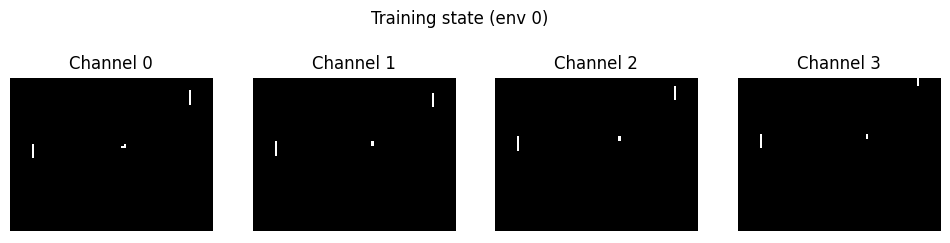

  1%|▏         | 199/15000 [03:59<5:00:46,  1.22s/it]

Episode 200 | Avg Episodic Reward (last 200): -20.11
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -5.9072
Critic Loss: 0.0499


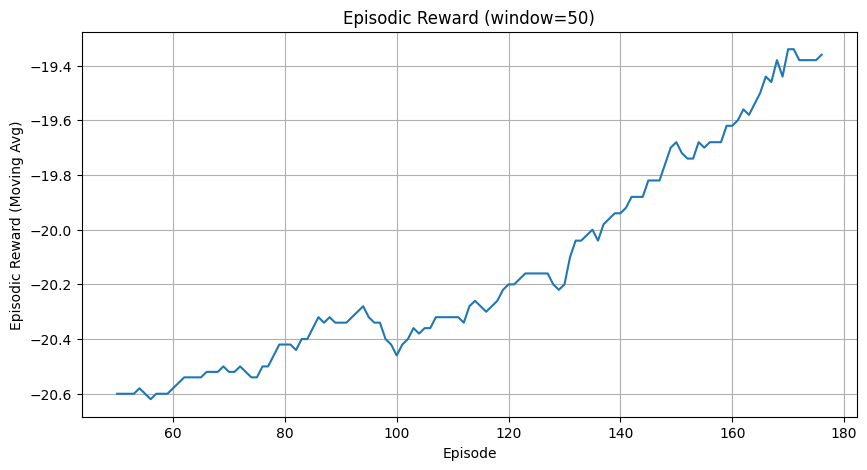

  3%|▎         | 399/15000 [07:57<4:28:01,  1.10s/it]

Episode 400 | Avg Episodic Reward (last 200): -18.78
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -14.8211
Critic Loss: 0.0346


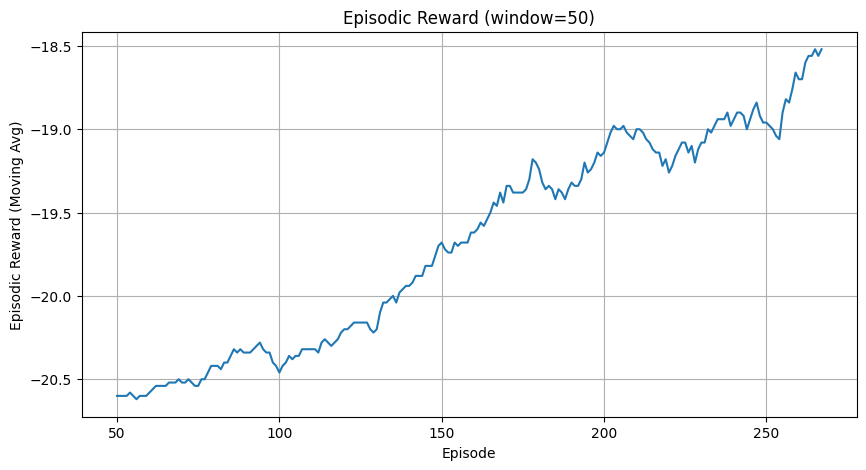

  4%|▍         | 599/15000 [11:56<4:37:23,  1.16s/it]

Episode 600 | Avg Episodic Reward (last 200): -17.31
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -14.6117
Critic Loss: 0.0330


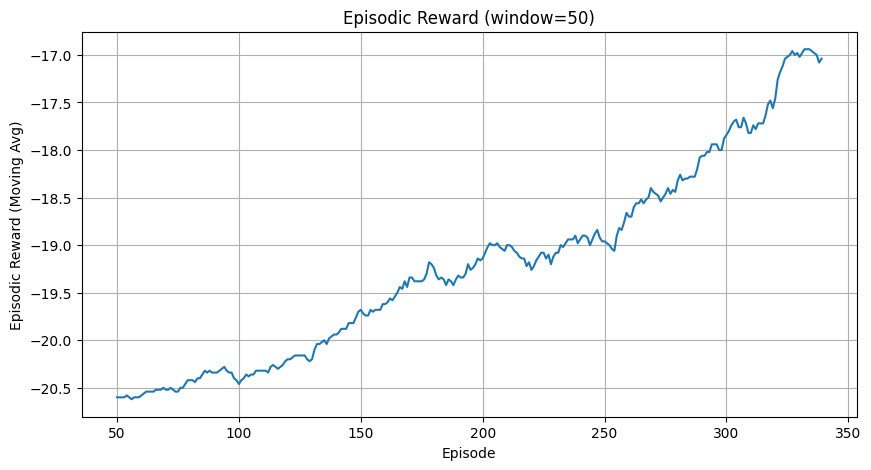

  5%|▌         | 799/15000 [15:56<4:37:29,  1.17s/it]

Episode 800 | Avg Episodic Reward (last 200): -15.74
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -13.5223
Critic Loss: 0.0304


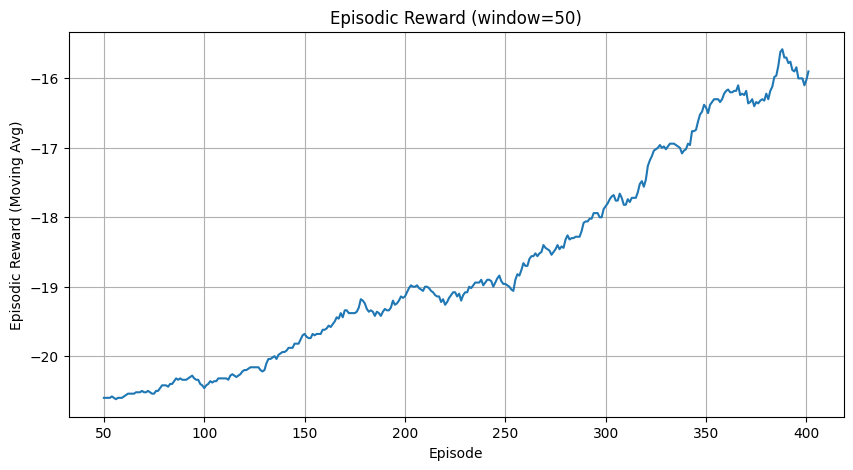

  7%|▋         | 999/15000 [19:54<4:21:57,  1.12s/it]

Episode 1000 | Avg Episodic Reward (last 200): -15.47
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -14.3402
Critic Loss: 0.0277


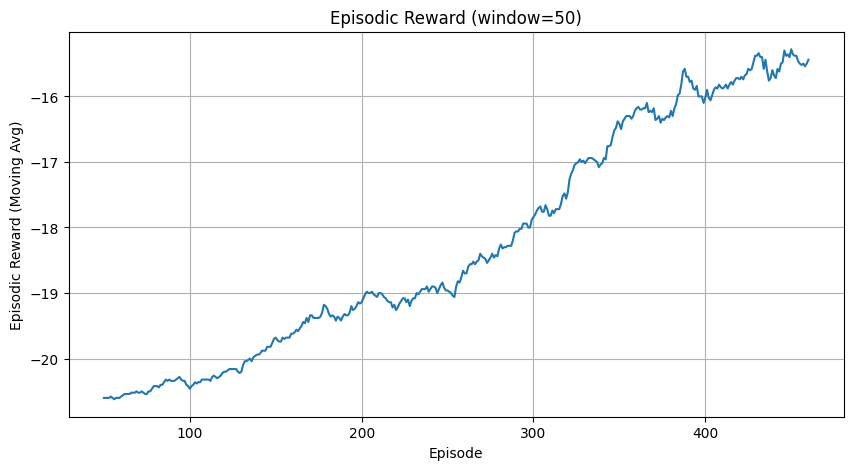

  8%|▊         | 1199/15000 [24:08<4:46:48,  1.25s/it]

Episode 1200 | Avg Episodic Reward (last 200): -14.91
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -15.9411
Critic Loss: 0.0240


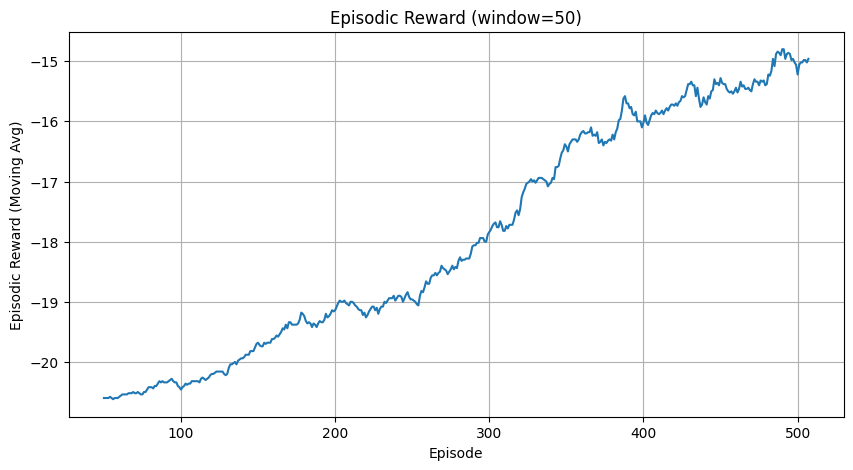

  9%|▉         | 1399/15000 [28:12<4:51:53,  1.29s/it]

Episode 1400 | Avg Episodic Reward (last 200): -14.77
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -12.8023
Critic Loss: 0.0236


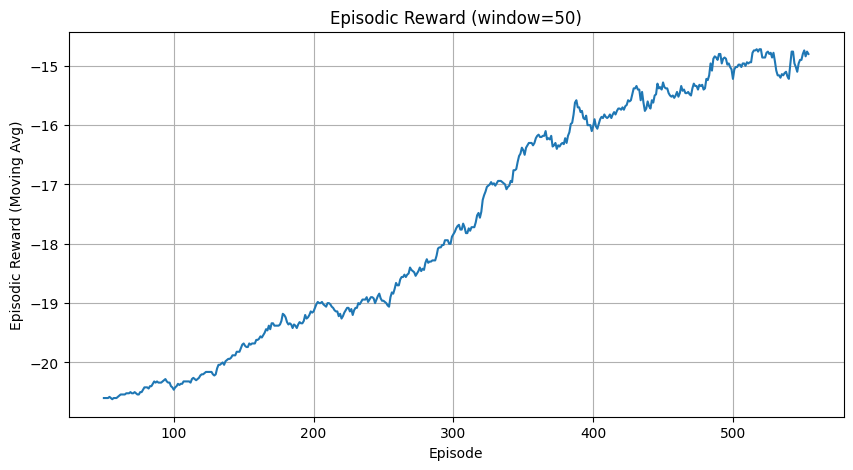

 11%|█         | 1599/15000 [32:13<4:49:41,  1.30s/it]

Episode 1600 | Avg Episodic Reward (last 200): -14.76
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -14.6132
Critic Loss: 0.0213


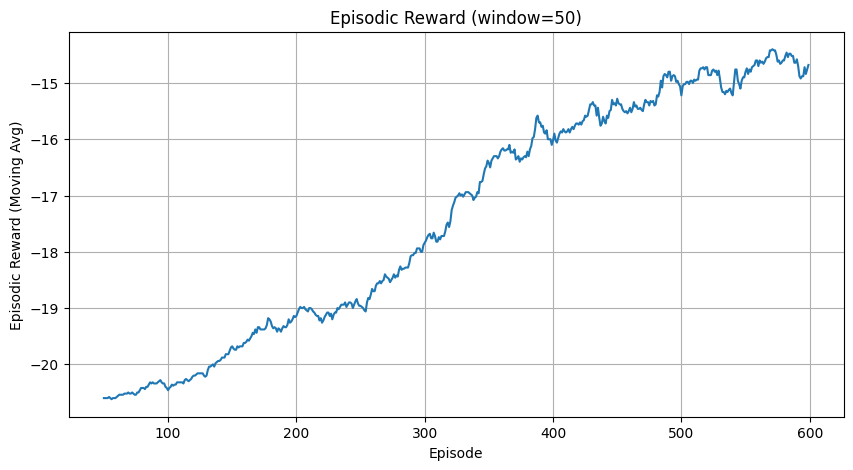

 12%|█▏        | 1799/15000 [40:22<13:35:00,  3.70s/it]

Episode 1800 | Avg Episodic Reward (last 200): -13.93
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -12.1153
Critic Loss: 0.0206


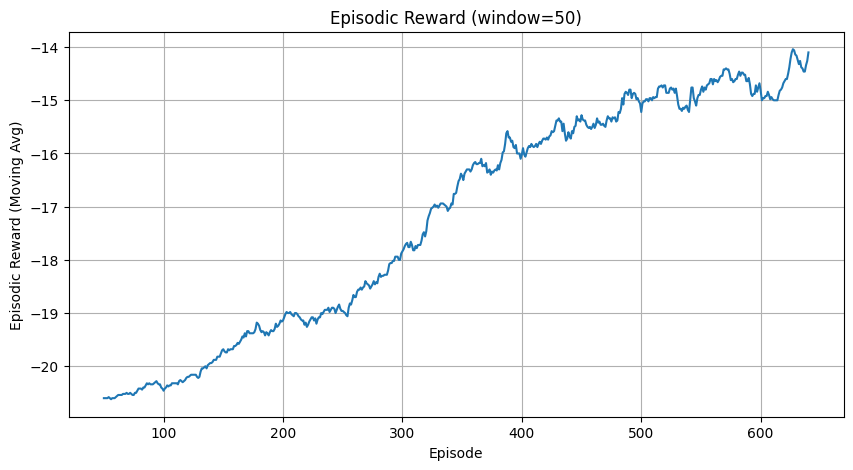

 13%|█▎        | 1999/15000 [52:26<14:04:44,  3.90s/it]

Episode 2000 | Avg Episodic Reward (last 200): -13.30
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -12.7715
Critic Loss: 0.0189


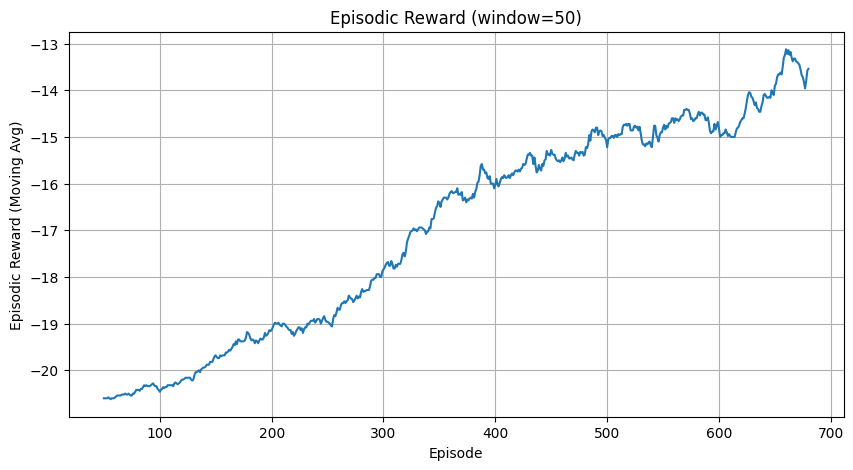

 15%|█▍        | 2199/15000 [1:05:21<14:14:15,  4.00s/it]

Episode 2200 | Avg Episodic Reward (last 200): -12.46
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.5500
Critic Loss: 0.0181


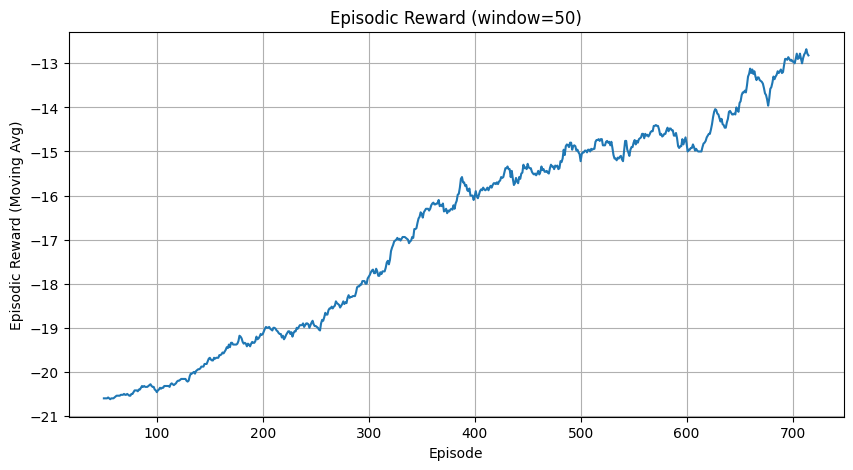

 16%|█▌        | 2399/15000 [1:18:25<13:32:42,  3.87s/it]

Episode 2400 | Avg Episodic Reward (last 200): -10.50
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -12.8018
Critic Loss: 0.0168


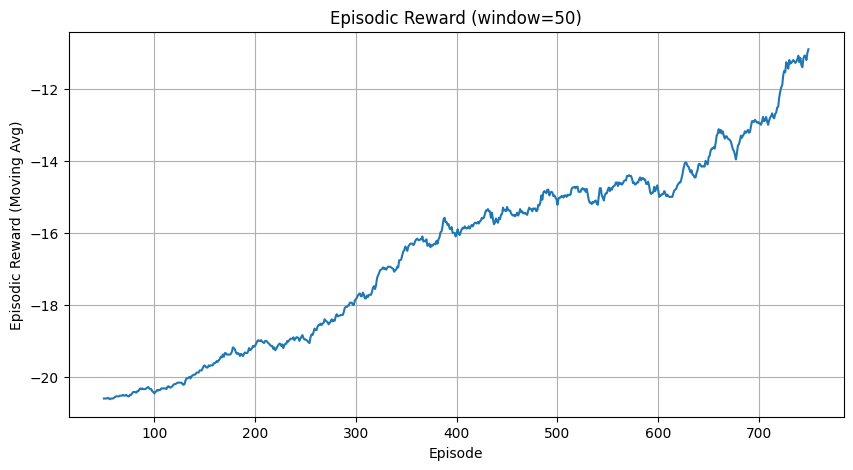

 17%|█▋        | 2599/15000 [1:28:52<12:07:22,  3.52s/it]

Episode 2600 | Avg Episodic Reward (last 200): -9.17
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.8363
Critic Loss: 0.0161


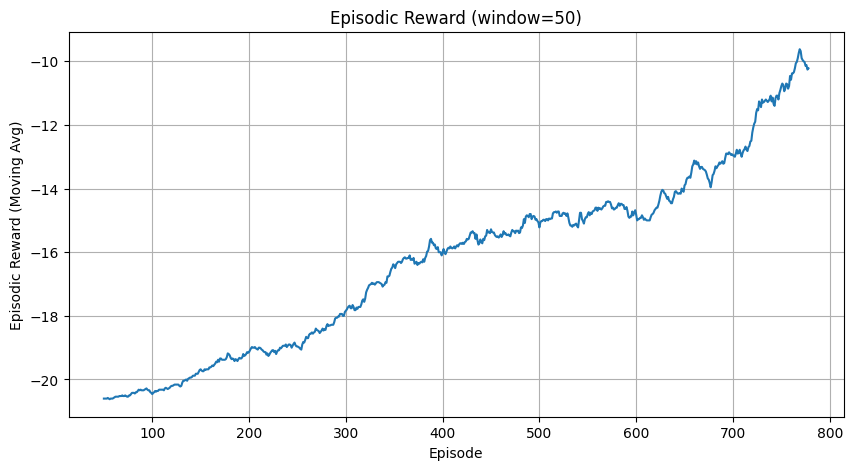

 19%|█▊        | 2799/15000 [1:36:12<4:03:06,  1.20s/it] 

Episode 2800 | Avg Episodic Reward (last 200): -6.83
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -13.3416
Critic Loss: 0.0164


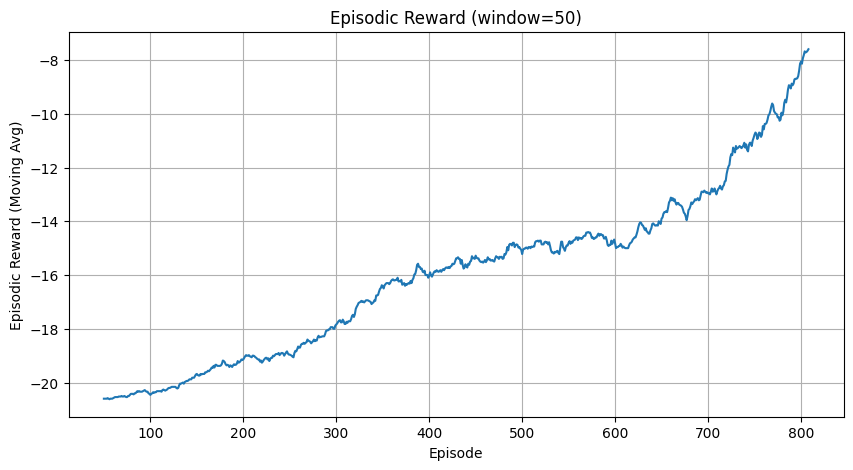

 20%|█▉        | 2999/15000 [1:41:36<13:13:16,  3.97s/it]

Episode 3000 | Avg Episodic Reward (last 200): -6.07
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.4491
Critic Loss: 0.0139


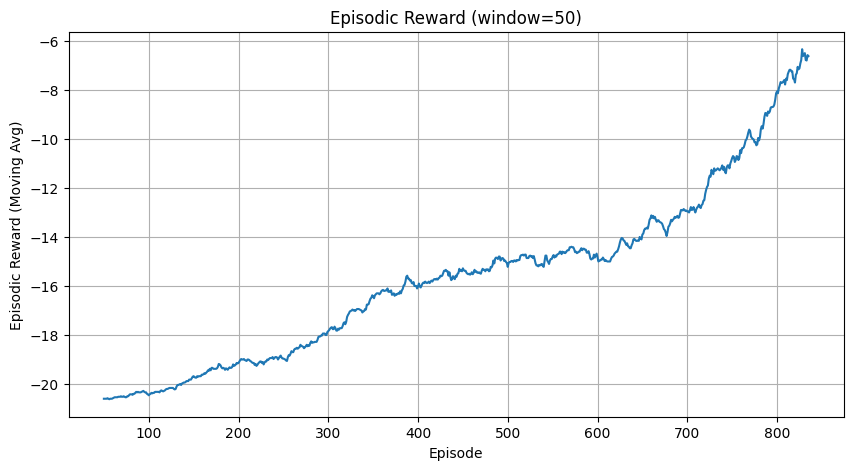

 21%|██▏       | 3199/15000 [1:54:25<12:51:29,  3.92s/it]

Episode 3200 | Avg Episodic Reward (last 200): -6.79
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -8.6125
Critic Loss: 0.0143


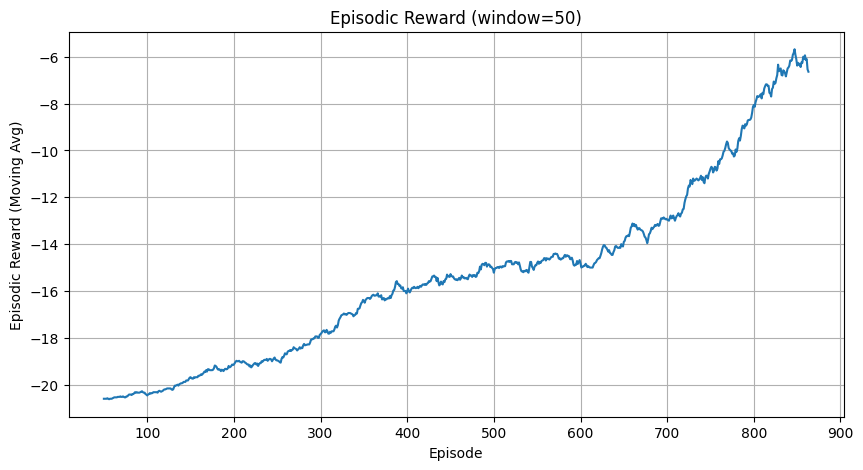

 23%|██▎       | 3399/15000 [2:06:46<13:11:01,  4.09s/it]

Episode 3400 | Avg Episodic Reward (last 200): -2.76
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.4612
Critic Loss: 0.0148


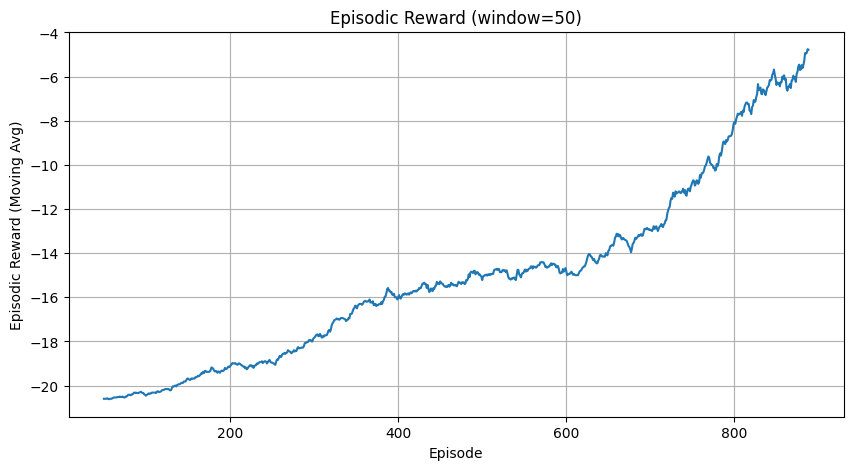

 24%|██▍       | 3599/15000 [2:18:53<5:58:04,  1.88s/it] 

Episode 3600 | Avg Episodic Reward (last 200): -3.79
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.3004
Critic Loss: 0.0144


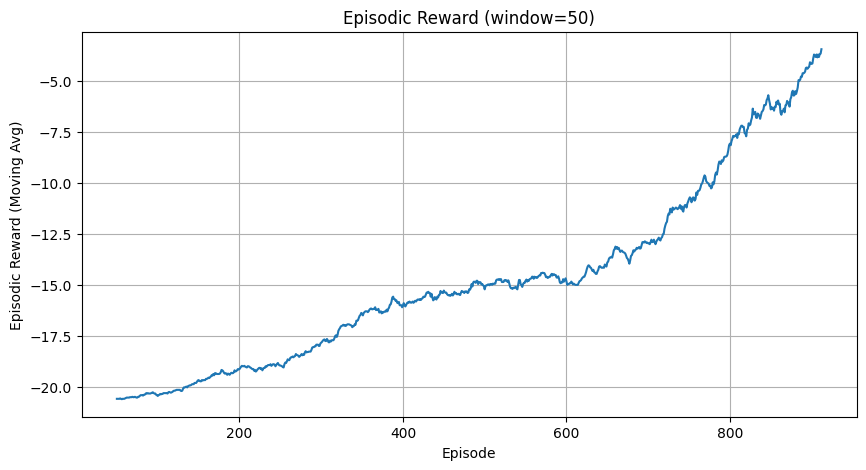

 25%|██▌       | 3799/15000 [2:25:15<4:03:05,  1.30s/it] 

Episode 3800 | Avg Episodic Reward (last 200): -1.70
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.7260
Critic Loss: 0.0136


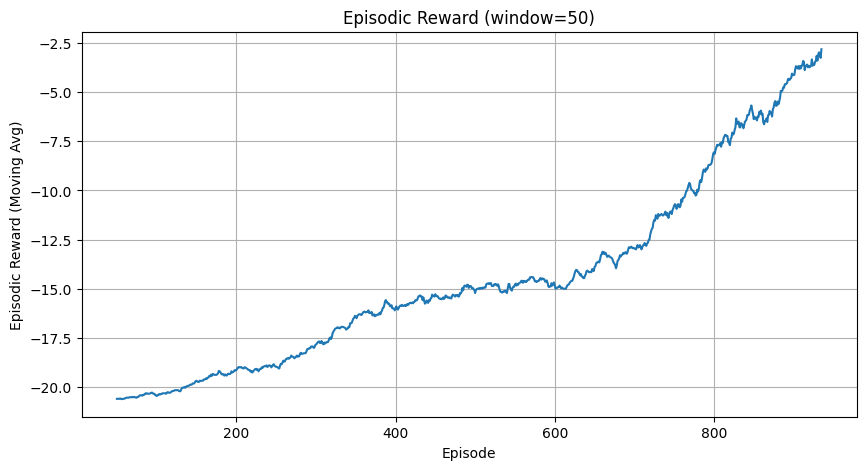

 27%|██▋       | 3999/15000 [2:36:59<9:58:39,  3.27s/it] 

Episode 4000 | Avg Episodic Reward (last 200): -1.86
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.5866
Critic Loss: 0.0128


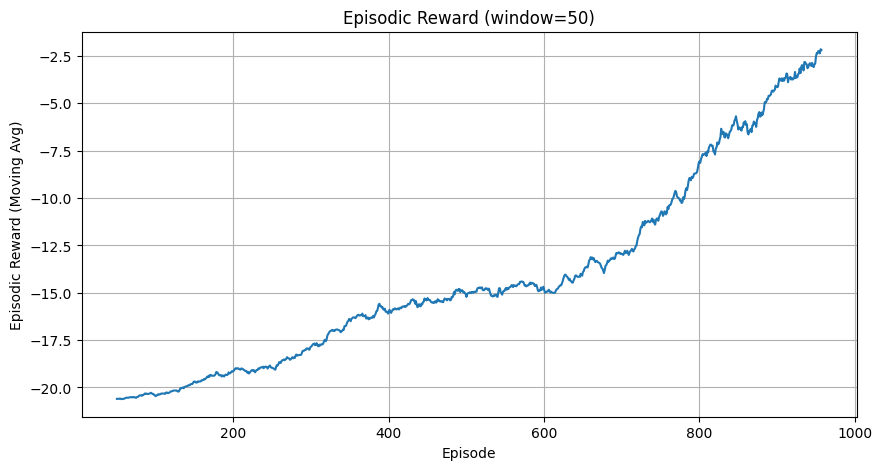

 28%|██▊       | 4199/15000 [2:47:44<9:51:44,  3.29s/it] 

Episode 4200 | Avg Episodic Reward (last 200): -1.41
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.3486
Critic Loss: 0.0133


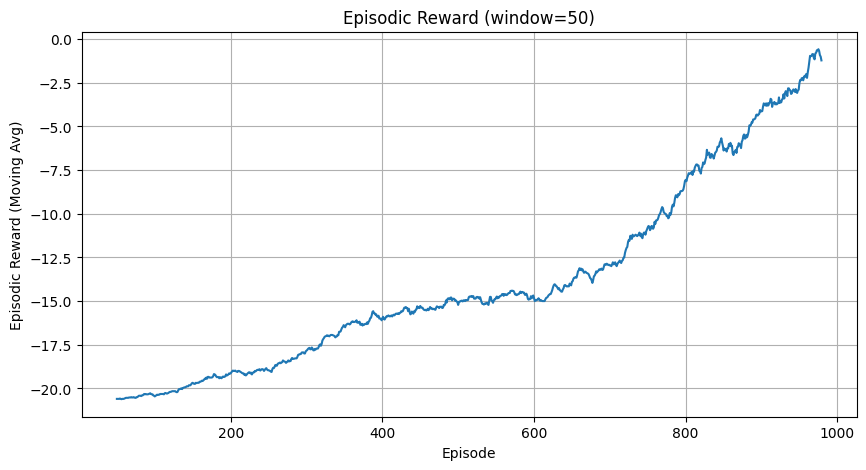

 29%|██▉       | 4399/15000 [3:00:47<12:14:39,  4.16s/it]

Episode 4400 | Avg Episodic Reward (last 200): -1.19
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.6530
Critic Loss: 0.0126


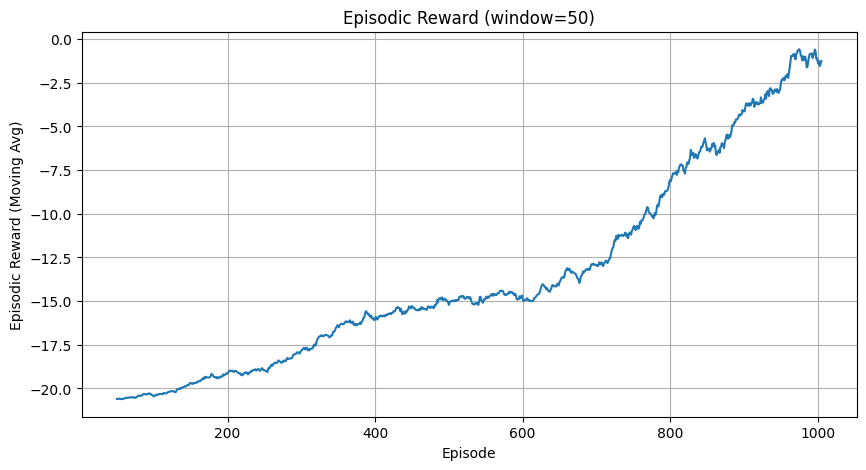

 31%|███       | 4599/15000 [3:07:12<3:49:54,  1.33s/it] 

Episode 4600 | Avg Episodic Reward (last 200): 3.29
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -12.9526
Critic Loss: 0.0128


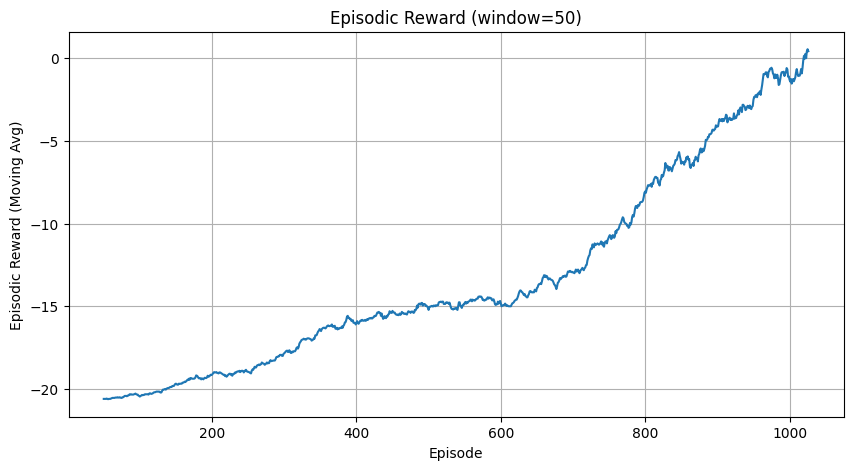

 32%|███▏      | 4799/15000 [3:11:18<3:39:05,  1.29s/it]

Episode 4800 | Avg Episodic Reward (last 200): 4.00
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.7340
Critic Loss: 0.0112


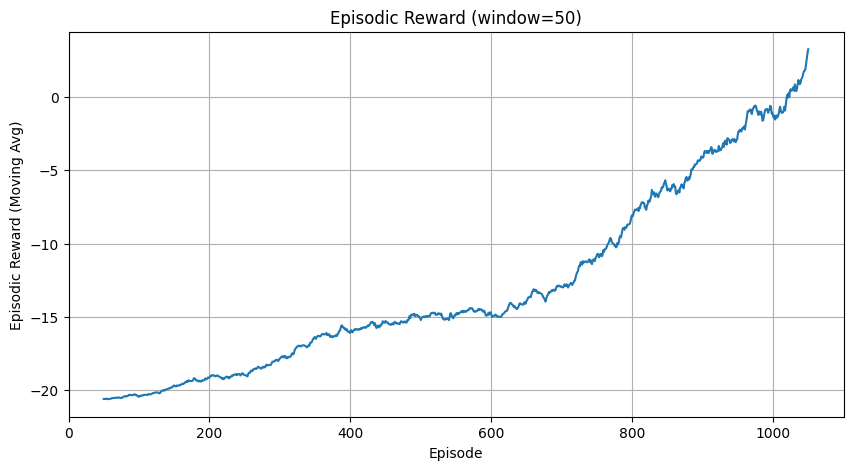

 33%|███▎      | 4999/15000 [3:15:22<3:33:11,  1.28s/it]

Episode 5000 | Avg Episodic Reward (last 200): 1.83
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.5363
Critic Loss: 0.0123


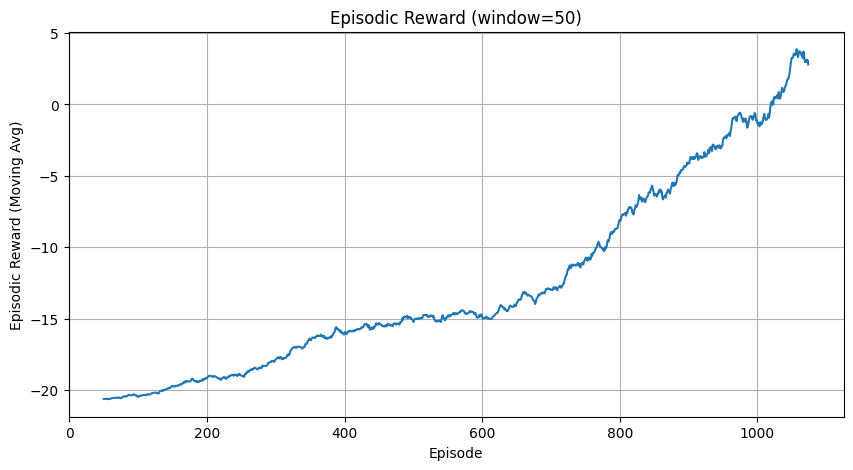

 35%|███▍      | 5199/15000 [3:19:26<3:28:25,  1.28s/it]

Episode 5200 | Avg Episodic Reward (last 200): 6.38
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.1764
Critic Loss: 0.0115


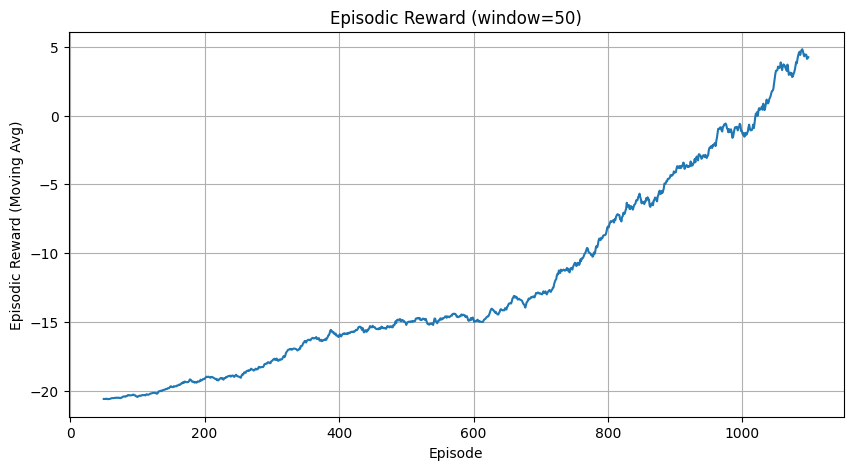

 36%|███▌      | 5399/15000 [3:23:33<3:11:01,  1.19s/it]

Episode 5400 | Avg Episodic Reward (last 200): 6.25
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.5109
Critic Loss: 0.0122


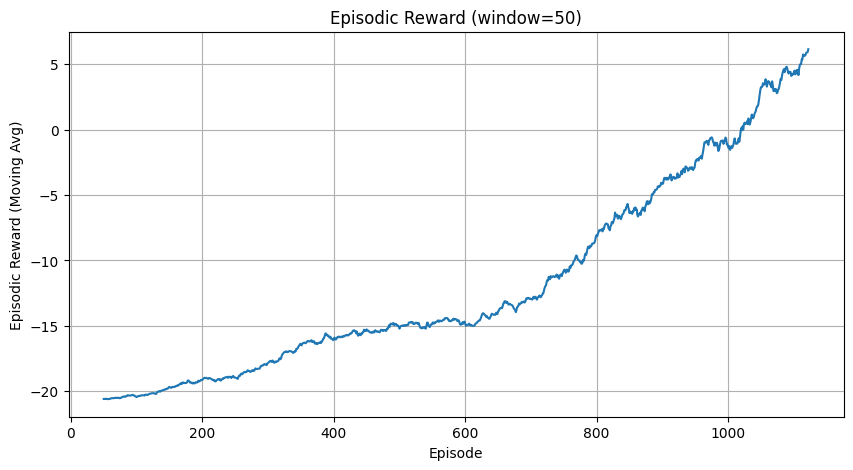

 37%|███▋      | 5599/15000 [3:27:41<2:59:39,  1.15s/it]

Episode 5600 | Avg Episodic Reward (last 200): 7.85
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.5967
Critic Loss: 0.0111


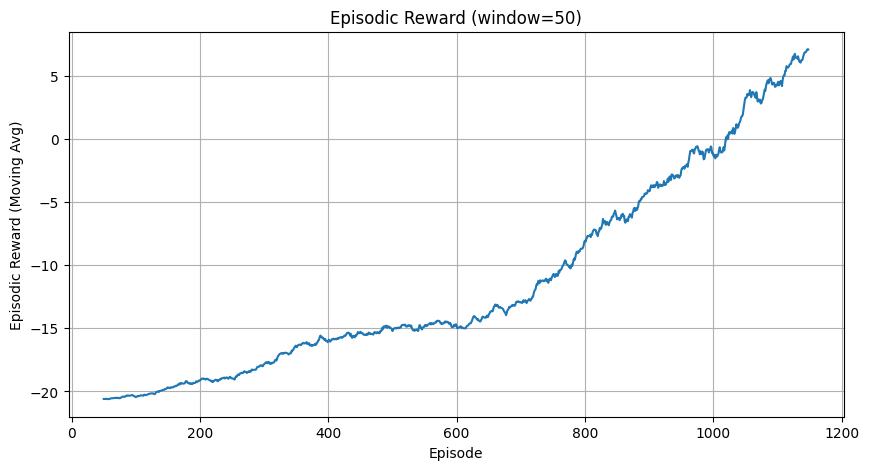

 39%|███▊      | 5799/15000 [3:31:45<3:00:38,  1.18s/it]

Episode 5800 | Avg Episodic Reward (last 200): 8.40
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.2318
Critic Loss: 0.0099


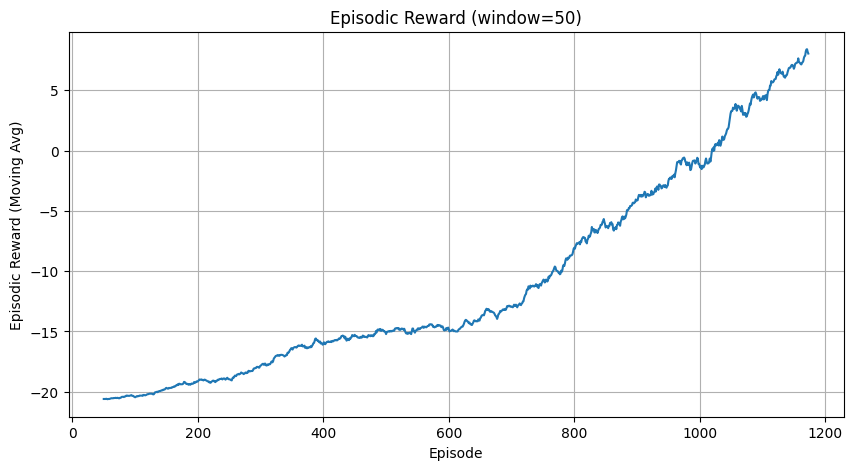

 40%|███▉      | 5999/15000 [3:35:52<3:04:04,  1.23s/it]

Episode 6000 | Avg Episodic Reward (last 200): 9.70
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -12.8229
Critic Loss: 0.0101


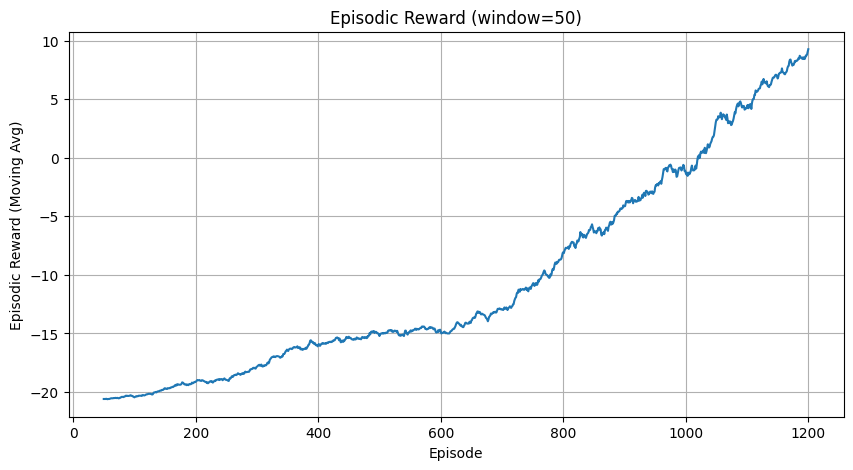

 41%|████▏     | 6199/15000 [3:40:01<3:08:37,  1.29s/it]

Episode 6200 | Avg Episodic Reward (last 200): 10.25
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.6669
Critic Loss: 0.0100


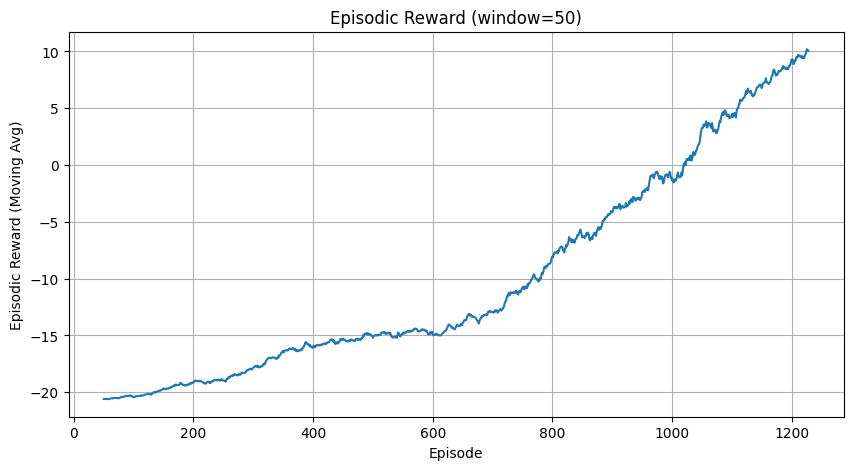

 43%|████▎     | 6399/15000 [3:44:06<2:57:13,  1.24s/it]

Episode 6400 | Avg Episodic Reward (last 200): 9.44
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.3137
Critic Loss: 0.0093


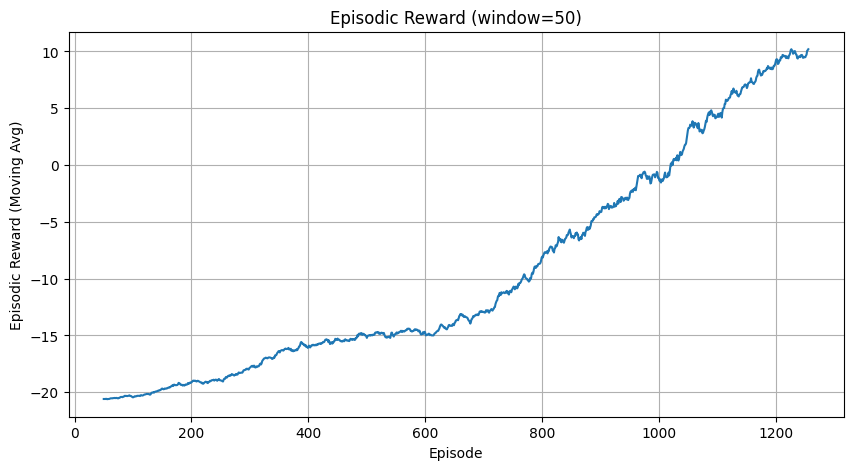

 44%|████▍     | 6599/15000 [3:48:12<2:54:30,  1.25s/it]

Episode 6600 | Avg Episodic Reward (last 200): 10.41
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.7257
Critic Loss: 0.0097


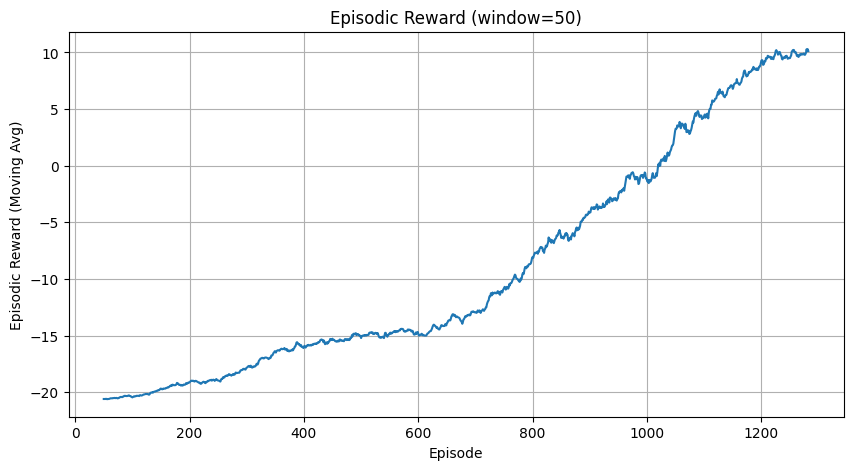

 45%|████▌     | 6799/15000 [3:52:19<2:42:36,  1.19s/it]

Episode 6800 | Avg Episodic Reward (last 200): 11.37
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.0145
Critic Loss: 0.0102


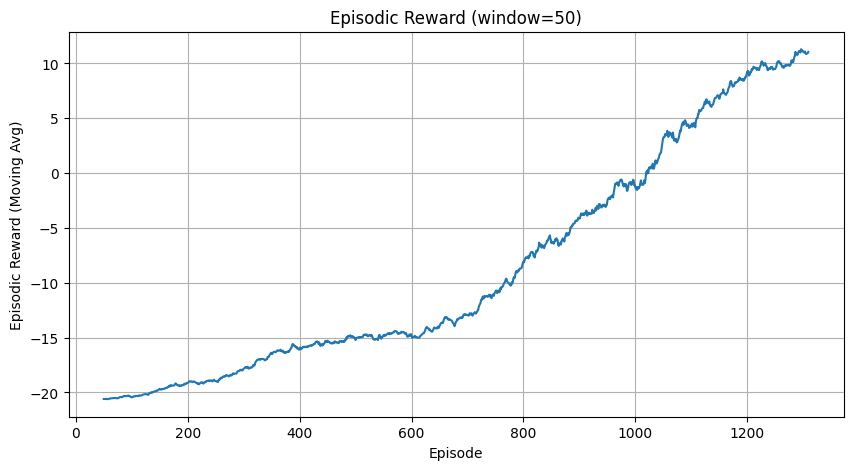

 47%|████▋     | 6999/15000 [3:56:23<2:47:47,  1.26s/it]

Episode 7000 | Avg Episodic Reward (last 200): 10.59
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.4310
Critic Loss: 0.0091


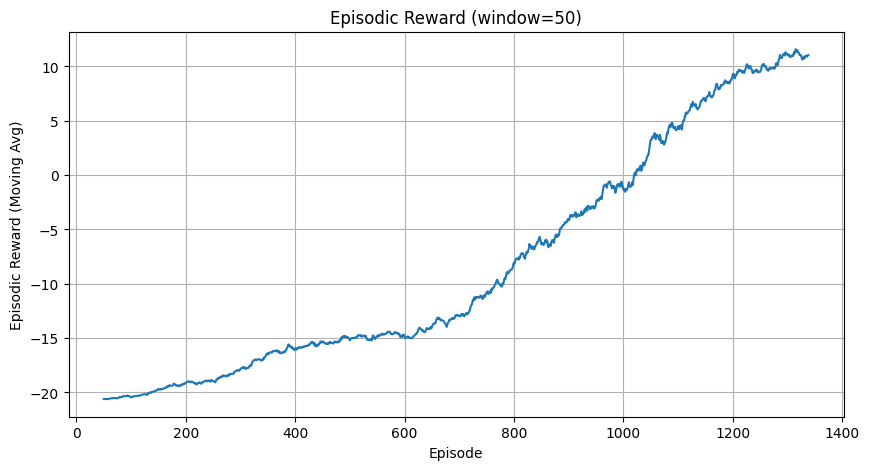

 48%|████▊     | 7199/15000 [4:00:27<2:38:37,  1.22s/it]

Episode 7200 | Avg Episodic Reward (last 200): 13.64
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.8110
Critic Loss: 0.0092


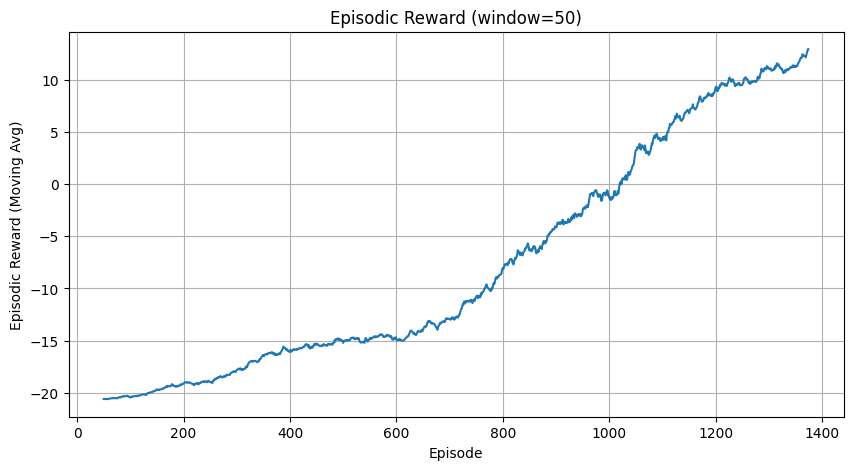

 49%|████▉     | 7399/15000 [4:04:35<2:25:19,  1.15s/it]

Episode 7400 | Avg Episodic Reward (last 200): 14.31
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.6283
Critic Loss: 0.0088


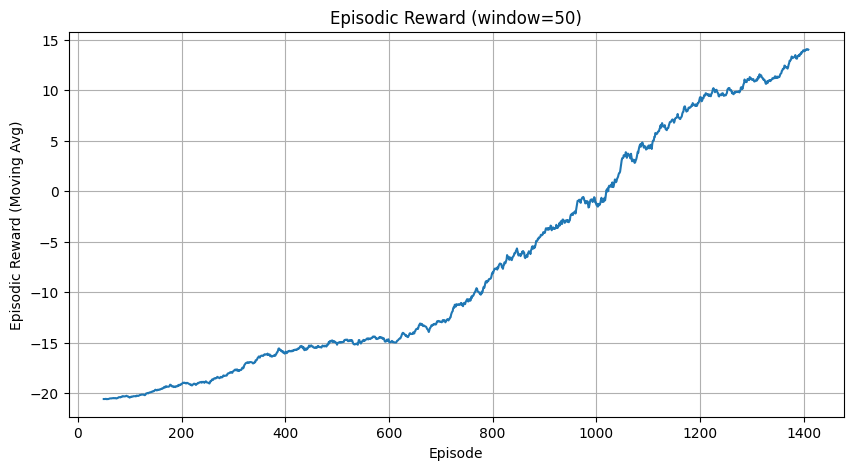

 51%|█████     | 7599/15000 [4:08:38<2:31:44,  1.23s/it]

Episode 7600 | Avg Episodic Reward (last 200): 12.75
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.7935
Critic Loss: 0.0093


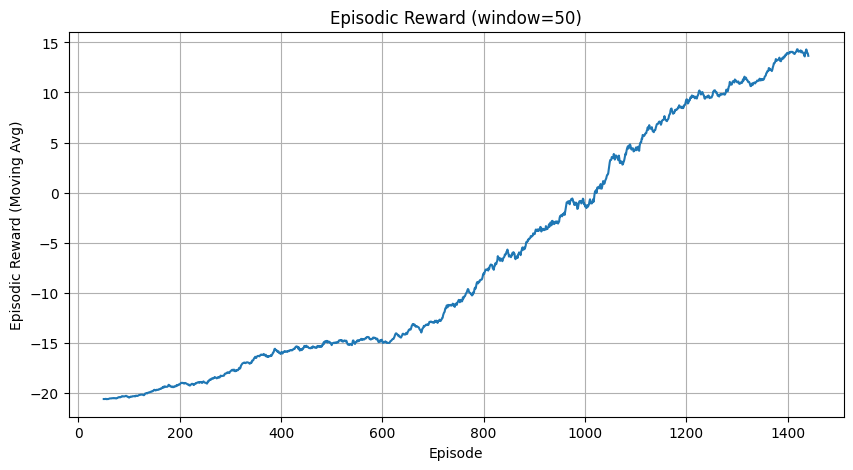

 52%|█████▏    | 7799/15000 [4:12:46<2:23:03,  1.19s/it]

Episode 7800 | Avg Episodic Reward (last 200): 12.33
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.7273
Critic Loss: 0.0080


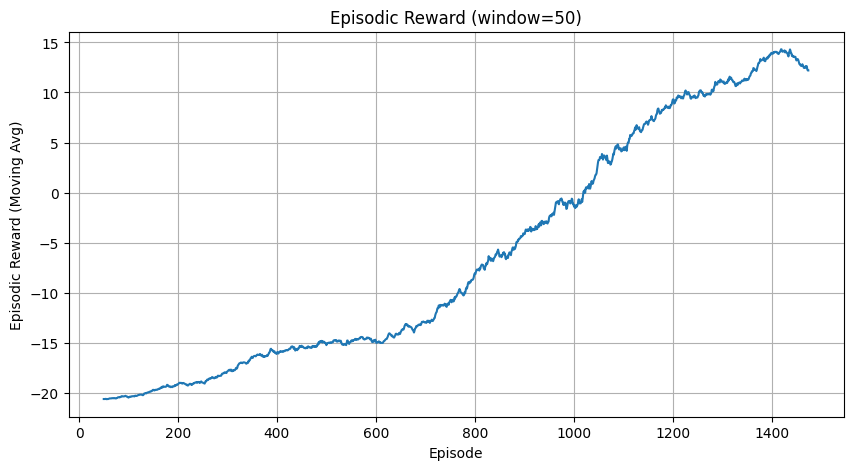

 53%|█████▎    | 7999/15000 [4:16:50<2:13:15,  1.14s/it]

Episode 8000 | Avg Episodic Reward (last 200): 14.65
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -12.0644
Critic Loss: 0.0080


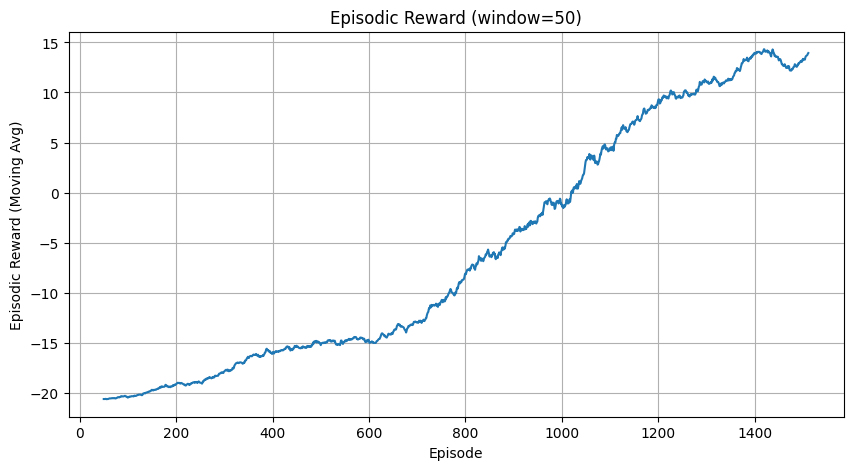

 55%|█████▍    | 8199/15000 [4:20:53<2:09:45,  1.14s/it]

Episode 8200 | Avg Episodic Reward (last 200): 13.52
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.9783
Critic Loss: 0.0084


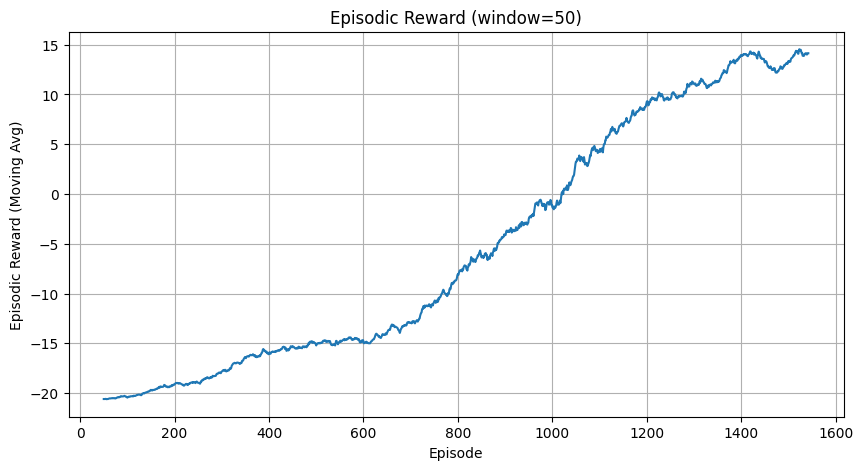

 56%|█████▌    | 8399/15000 [4:25:01<2:12:59,  1.21s/it]

Episode 8400 | Avg Episodic Reward (last 200): 13.74
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.8075
Critic Loss: 0.0091


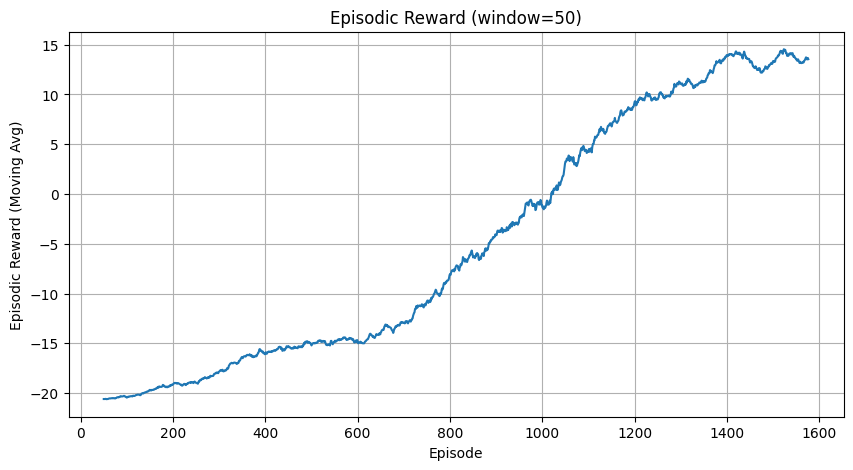

 57%|█████▋    | 8599/15000 [4:29:09<2:07:59,  1.20s/it]

Episode 8600 | Avg Episodic Reward (last 200): 13.23
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.7429
Critic Loss: 0.0079


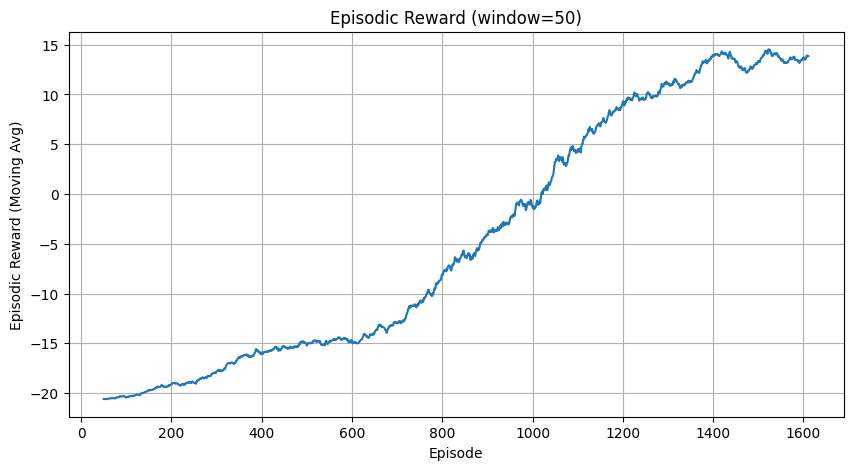

 59%|█████▊    | 8799/15000 [4:33:18<2:03:01,  1.19s/it]

Episode 8800 | Avg Episodic Reward (last 200): 15.00
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.9492
Critic Loss: 0.0073


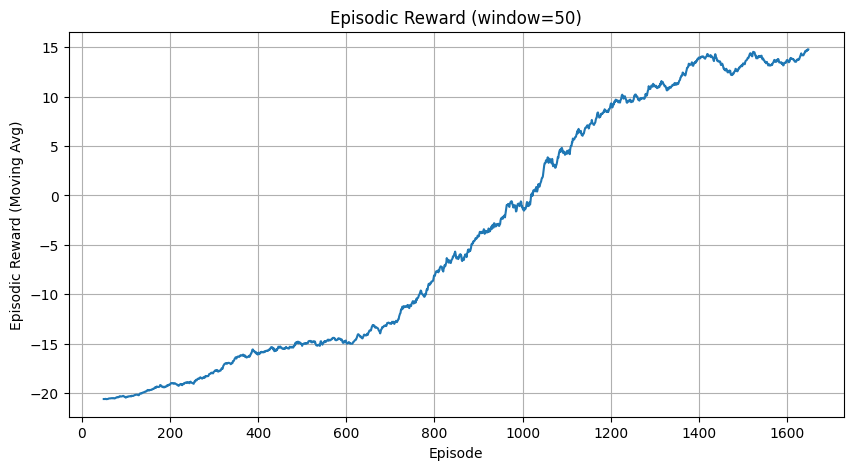

 60%|█████▉    | 8999/15000 [4:37:25<1:57:38,  1.18s/it]

Episode 9000 | Avg Episodic Reward (last 200): 15.18
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.4074
Critic Loss: 0.0074


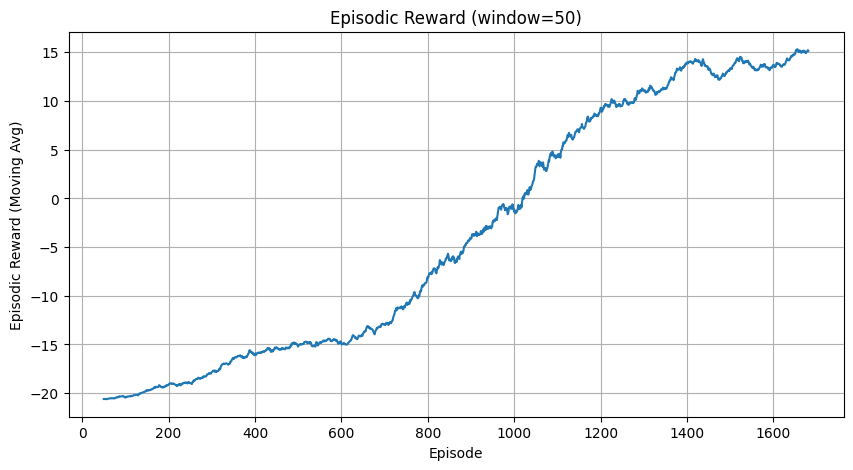

 61%|██████▏   | 9199/15000 [4:41:32<1:54:01,  1.18s/it]

Episode 9200 | Avg Episodic Reward (last 200): 13.94
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.5697
Critic Loss: 0.0087


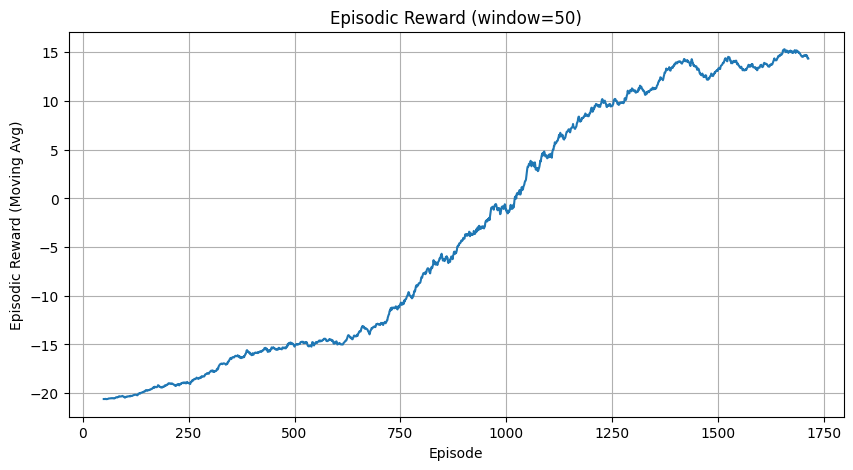

 63%|██████▎   | 9399/15000 [4:45:40<1:52:28,  1.20s/it]

Episode 9400 | Avg Episodic Reward (last 200): 12.73
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.3137
Critic Loss: 0.0078


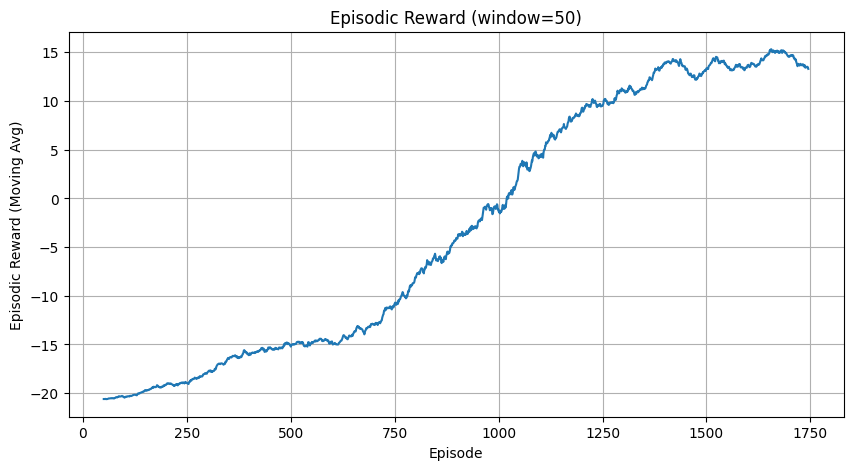

 64%|██████▍   | 9599/15000 [4:49:53<1:56:36,  1.30s/it]

Episode 9600 | Avg Episodic Reward (last 200): 15.18
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.7098
Critic Loss: 0.0068


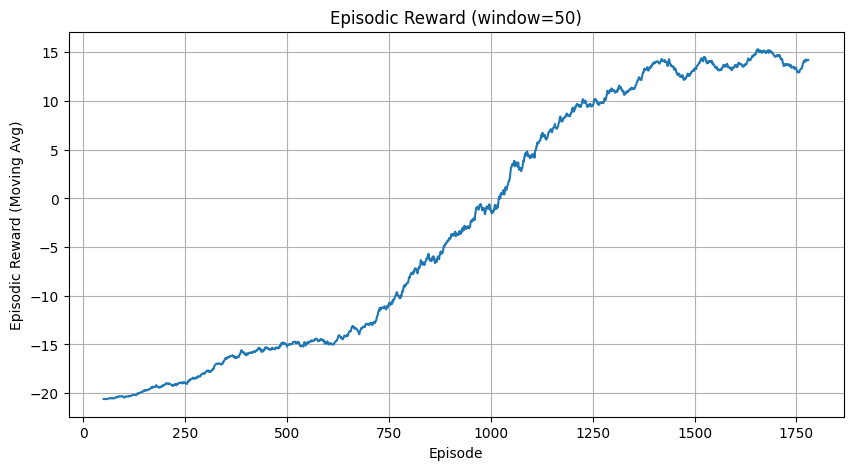

 65%|██████▌   | 9799/15000 [4:54:16<1:57:47,  1.36s/it]

Episode 9800 | Avg Episodic Reward (last 200): 15.65
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.1942
Critic Loss: 0.0070


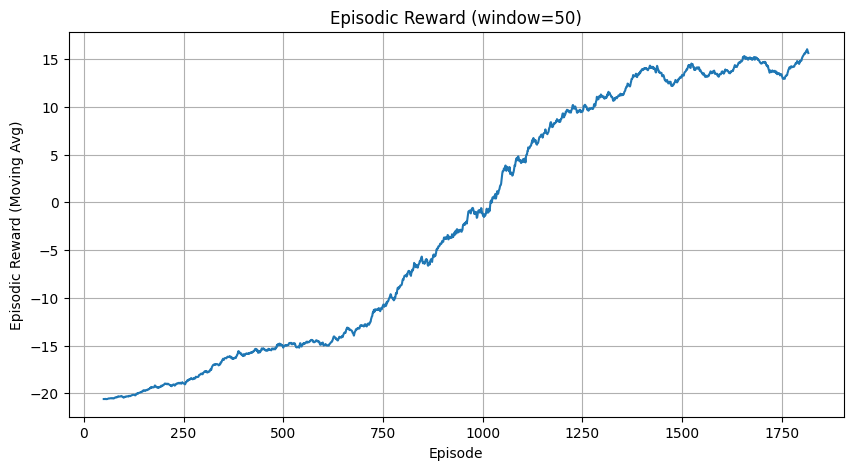

 67%|██████▋   | 9999/15000 [4:58:39<1:49:18,  1.31s/it]

Episode 10000 | Avg Episodic Reward (last 200): 15.39
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.6674
Critic Loss: 0.0066


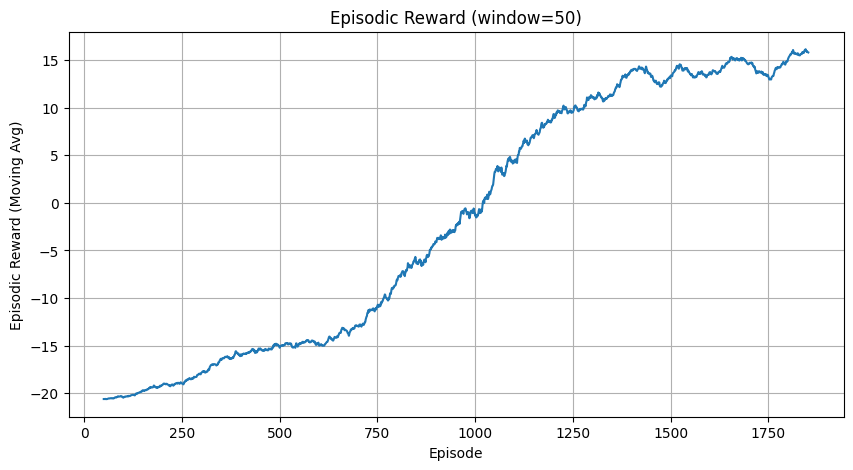

 68%|██████▊   | 10199/15000 [5:03:02<1:49:24,  1.37s/it]

Episode 10200 | Avg Episodic Reward (last 200): 15.03
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.3492
Critic Loss: 0.0064


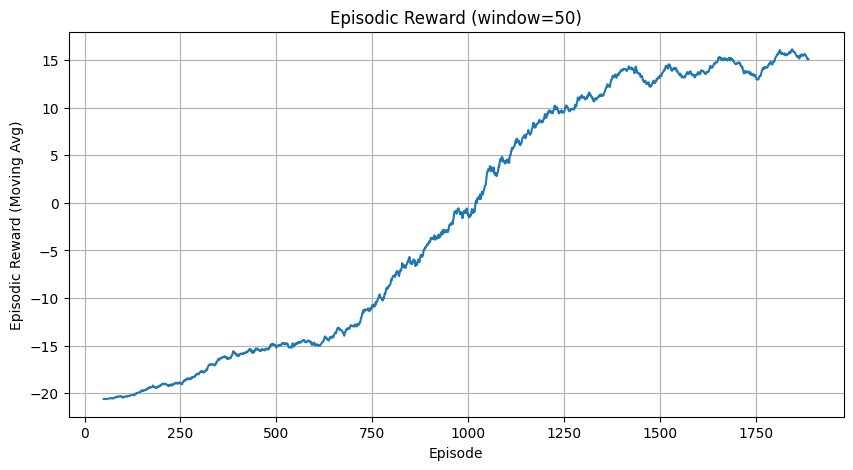

 69%|██████▉   | 10399/15000 [5:07:25<1:46:32,  1.39s/it]

Episode 10400 | Avg Episodic Reward (last 200): 15.17
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.2557
Critic Loss: 0.0069


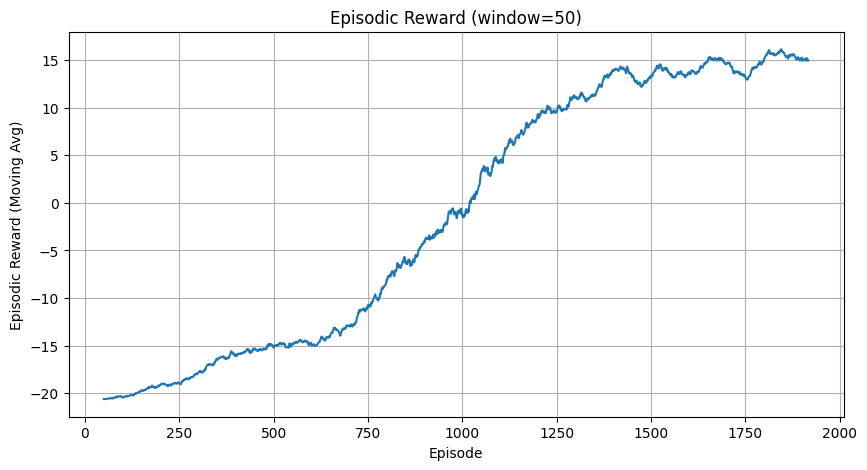

 71%|███████   | 10599/15000 [5:11:45<1:23:19,  1.14s/it]

Episode 10600 | Avg Episodic Reward (last 200): 16.32
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.8895
Critic Loss: 0.0068


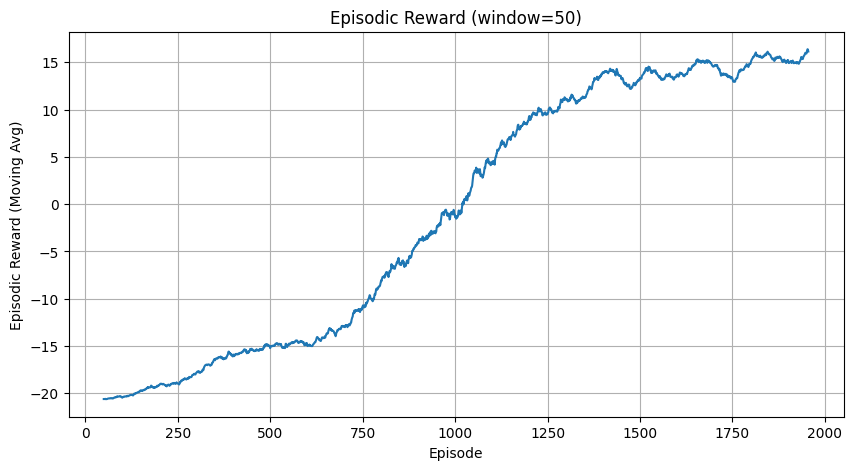

 72%|███████▏  | 10799/15000 [5:15:49<1:19:45,  1.14s/it]

Episode 10800 | Avg Episodic Reward (last 200): 14.30
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.1114
Critic Loss: 0.0061


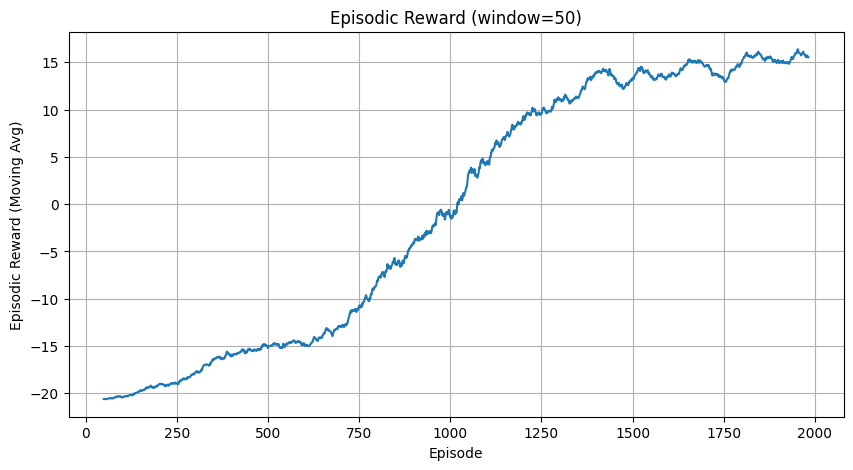

 73%|███████▎  | 10999/15000 [5:19:55<1:24:36,  1.27s/it]

Episode 11000 | Avg Episodic Reward (last 200): 14.78
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.1850
Critic Loss: 0.0062


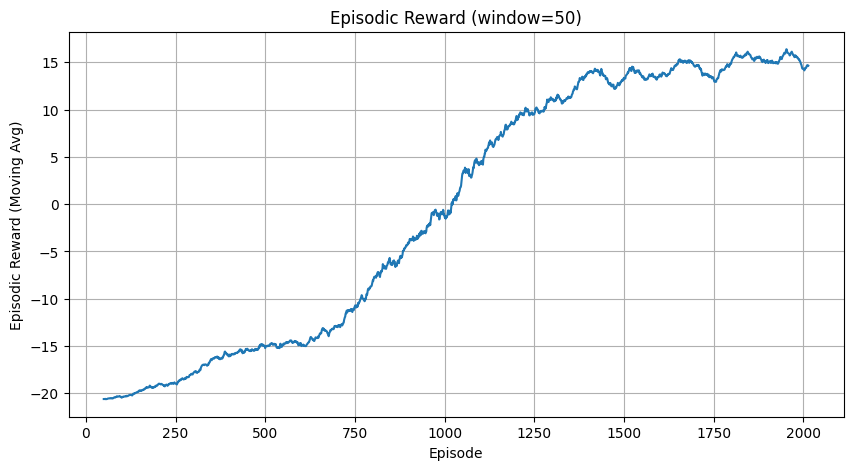

 75%|███████▍  | 11199/15000 [5:24:02<1:19:56,  1.26s/it]

Episode 11200 | Avg Episodic Reward (last 200): 15.12
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.0376
Critic Loss: 0.0067


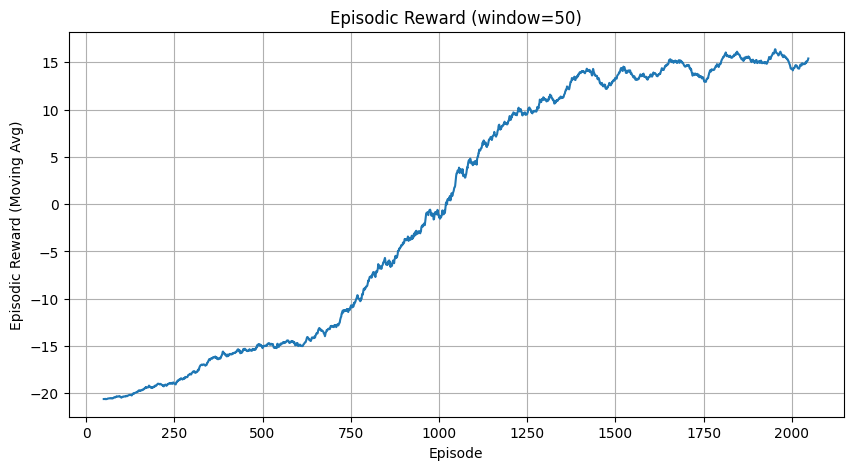

 76%|███████▌  | 11399/15000 [5:28:09<1:14:32,  1.24s/it]

Episode 11400 | Avg Episodic Reward (last 200): 14.00
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.9178
Critic Loss: 0.0060


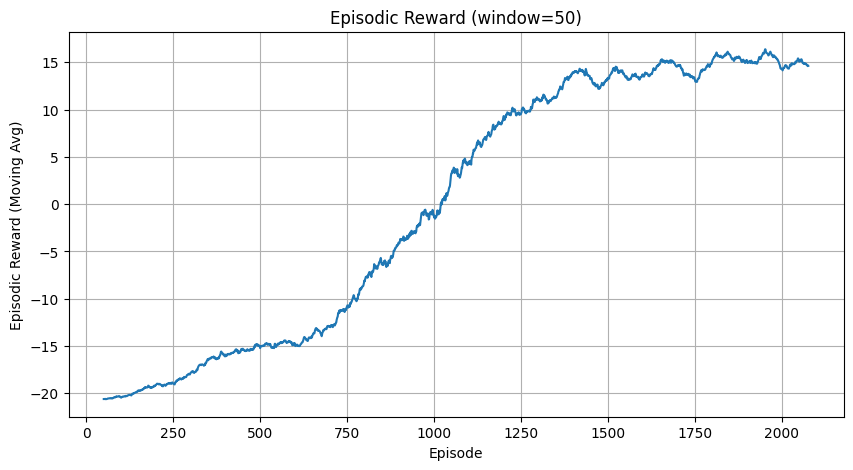

 77%|███████▋  | 11599/15000 [5:32:13<1:09:37,  1.23s/it]

Episode 11600 | Avg Episodic Reward (last 200): 15.53
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.9550
Critic Loss: 0.0059


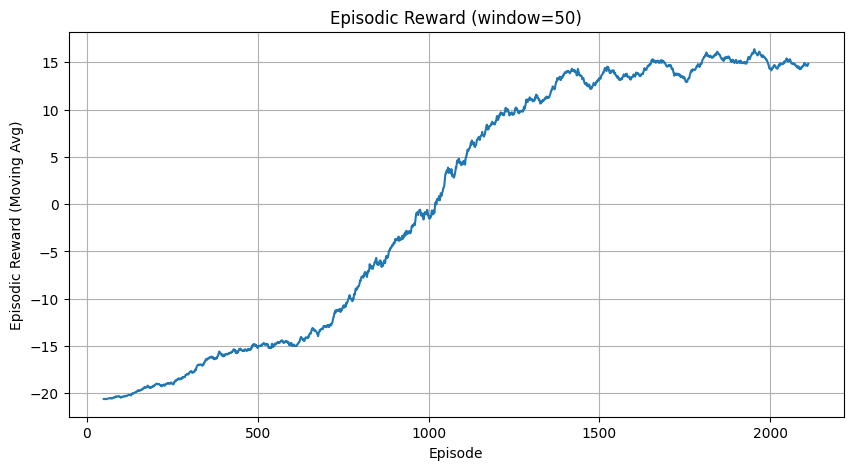

 79%|███████▊  | 11799/15000 [5:36:21<1:09:50,  1.31s/it]

Episode 11800 | Avg Episodic Reward (last 200): 16.38
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -12.3395
Critic Loss: 0.0051


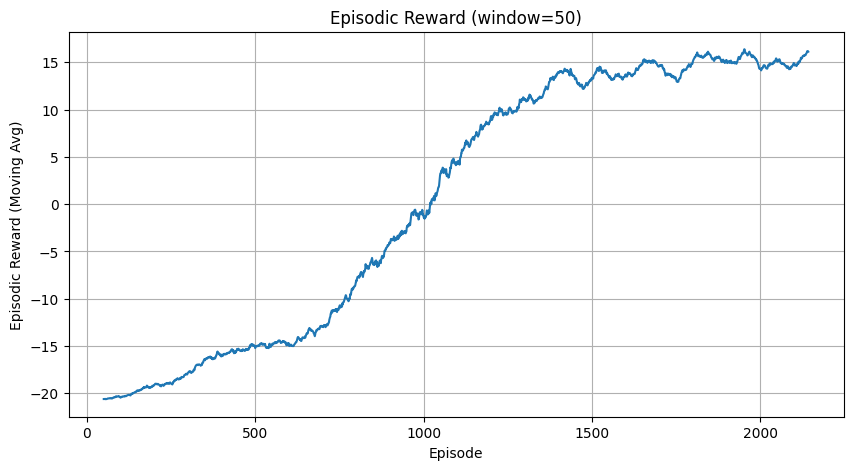

 80%|███████▉  | 11999/15000 [5:40:28<58:41,  1.17s/it]  

Episode 12000 | Avg Episodic Reward (last 200): 15.55
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.4327
Critic Loss: 0.0051


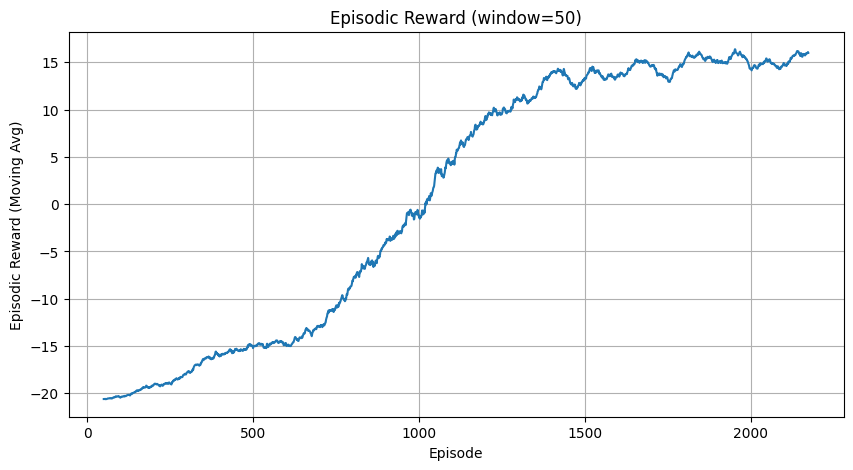

 81%|████████▏ | 12199/15000 [5:44:33<54:53,  1.18s/it]  

Episode 12200 | Avg Episodic Reward (last 200): 12.63
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.4115
Critic Loss: 0.0074


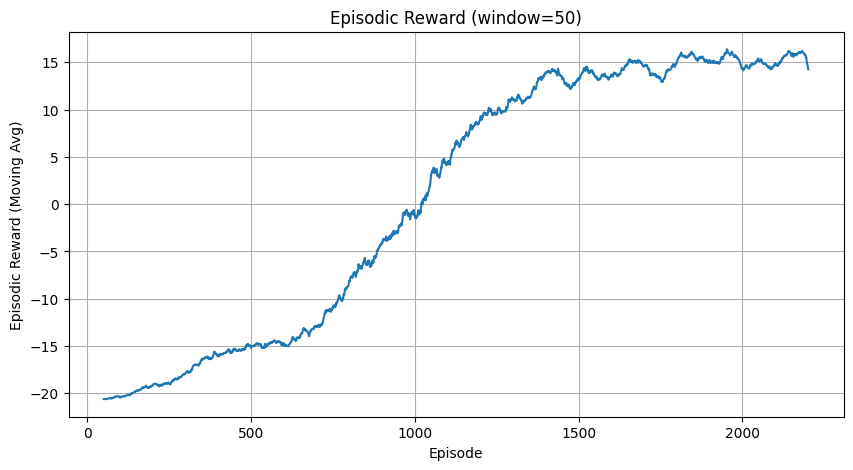

 83%|████████▎ | 12399/15000 [5:48:40<51:14,  1.18s/it]  

Episode 12400 | Avg Episodic Reward (last 200): 14.70
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.9127
Critic Loss: 0.0061


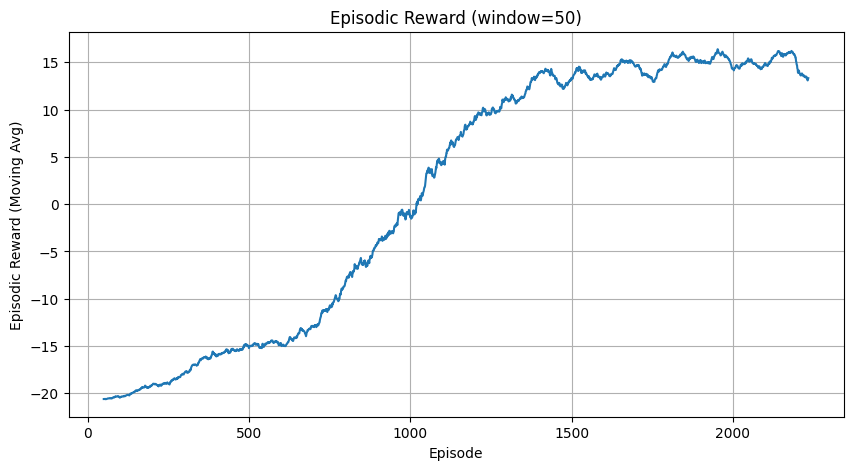

 84%|████████▍ | 12599/15000 [5:52:46<46:48,  1.17s/it]

Episode 12600 | Avg Episodic Reward (last 200): 16.13
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.8908
Critic Loss: 0.0049


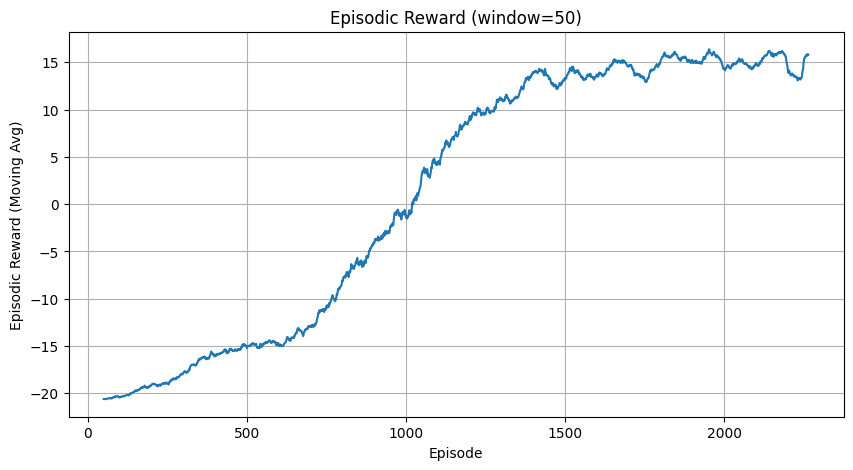

 85%|████████▌ | 12799/15000 [5:56:53<43:59,  1.20s/it]

Episode 12800 | Avg Episodic Reward (last 200): 16.00
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.5035
Critic Loss: 0.0051


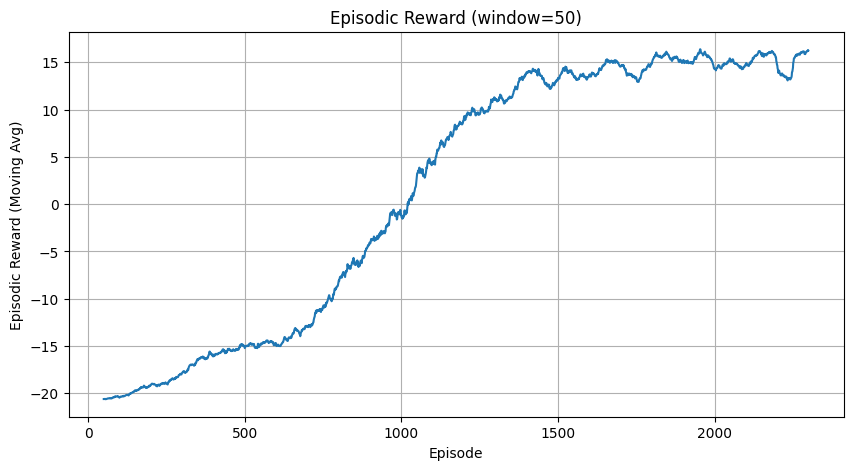

 87%|████████▋ | 12999/15000 [6:01:00<39:24,  1.18s/it]

Episode 13000 | Avg Episodic Reward (last 200): 15.50
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.7417
Critic Loss: 0.0050


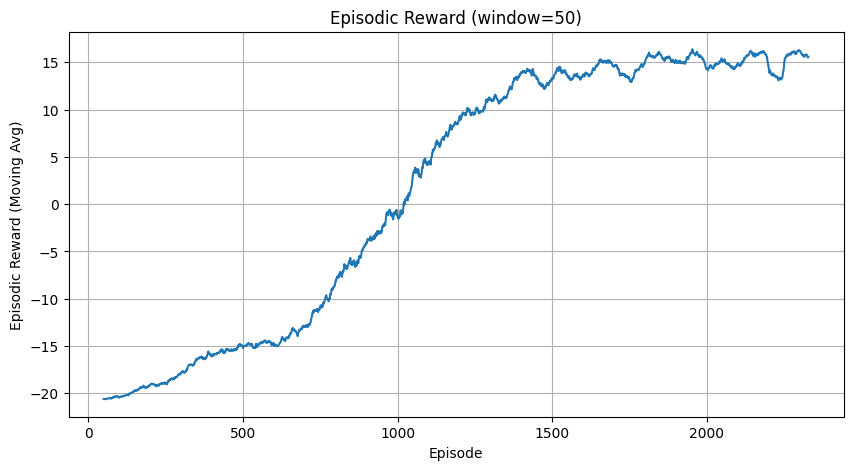

 88%|████████▊ | 13199/15000 [6:05:06<35:05,  1.17s/it]

Episode 13200 | Avg Episodic Reward (last 200): 15.06
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.7179
Critic Loss: 0.0058


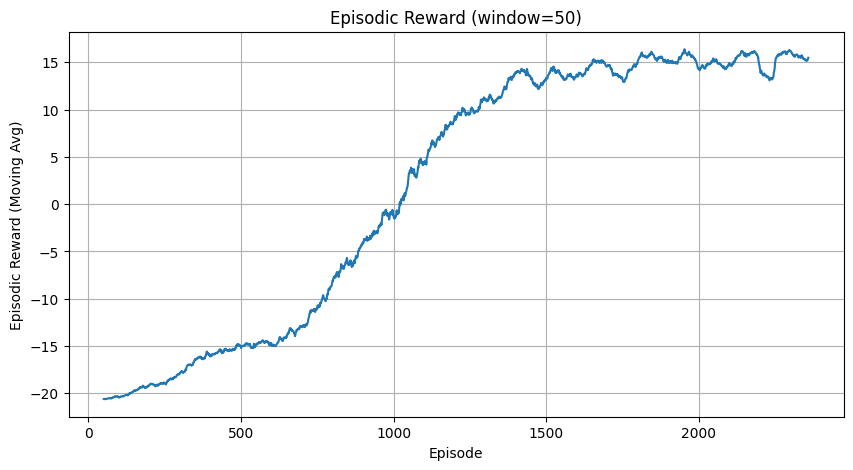

 89%|████████▉ | 13399/15000 [6:09:13<33:38,  1.26s/it]

Episode 13400 | Avg Episodic Reward (last 200): 15.94
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.5171
Critic Loss: 0.0054


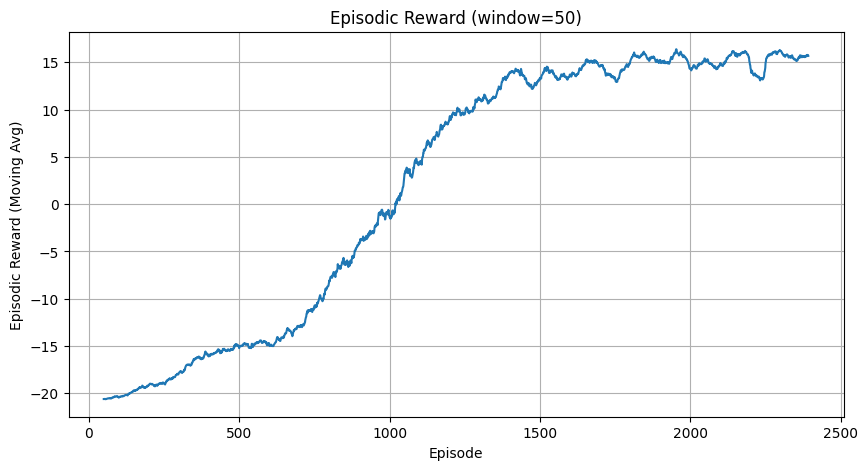

 91%|█████████ | 13599/15000 [6:13:37<31:11,  1.34s/it]

Episode 13600 | Avg Episodic Reward (last 200): 16.41
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.9805
Critic Loss: 0.0056


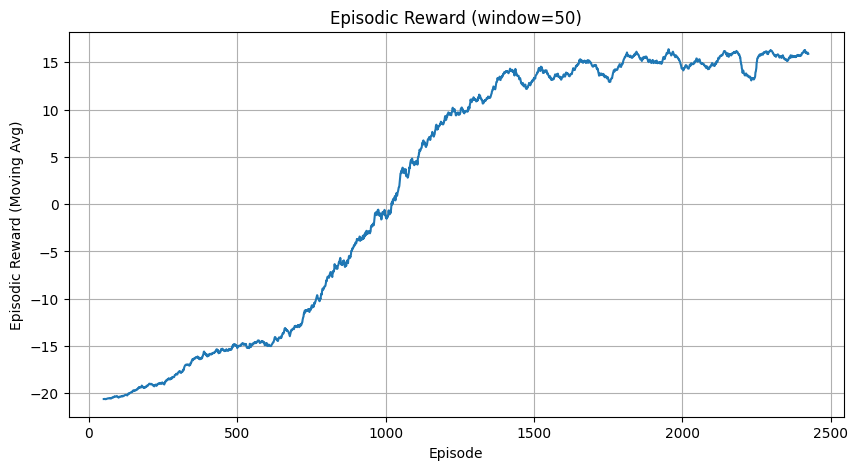

 92%|█████████▏| 13799/15000 [6:17:59<26:38,  1.33s/it]

Episode 13800 | Avg Episodic Reward (last 200): 15.71
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -9.2262
Critic Loss: 0.0057


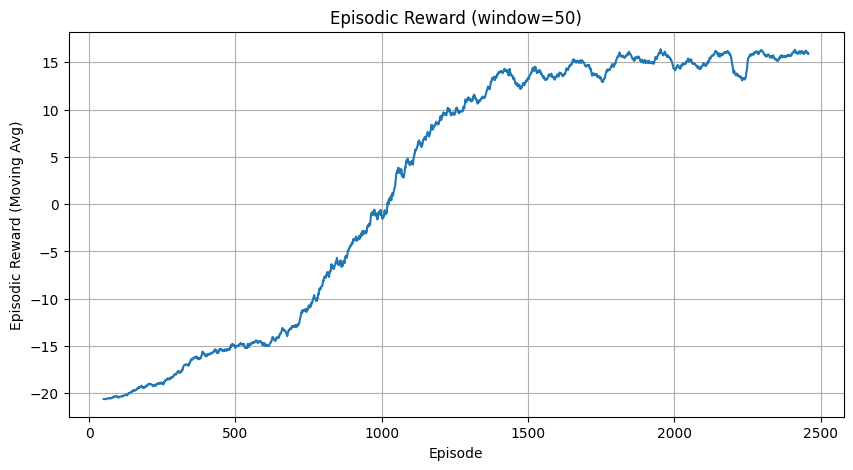

 93%|█████████▎| 13999/15000 [6:22:26<23:14,  1.39s/it]

Episode 14000 | Avg Episodic Reward (last 200): 15.94
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.7788
Critic Loss: 0.0052


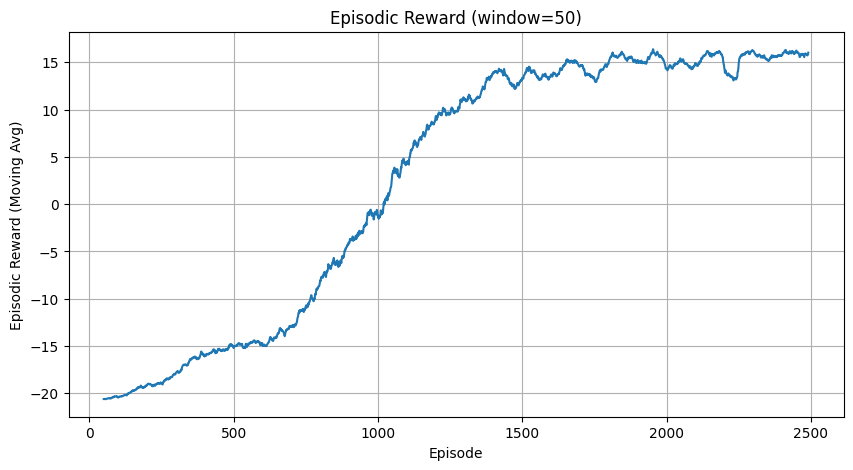

 95%|█████████▍| 14199/15000 [6:26:51<17:36,  1.32s/it]

Episode 14200 | Avg Episodic Reward (last 200): 14.38
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.1389
Critic Loss: 0.0057


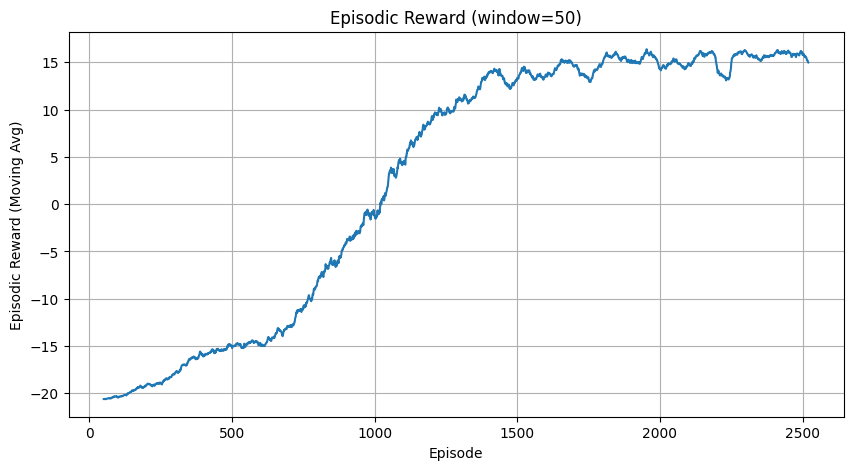

 96%|█████████▌| 14399/15000 [6:31:16<13:40,  1.36s/it]

Episode 14400 | Avg Episodic Reward (last 200): 15.38
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.5856
Critic Loss: 0.0048


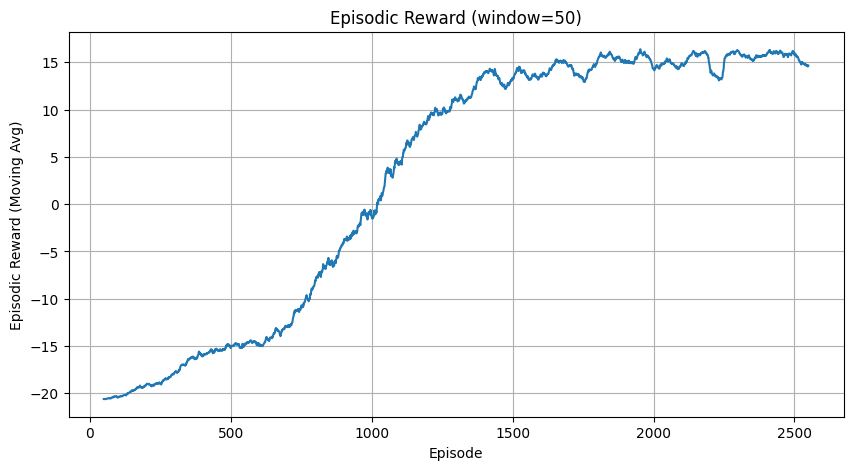

 97%|█████████▋| 14599/15000 [6:35:40<08:19,  1.25s/it]

Episode 14600 | Avg Episodic Reward (last 200): 16.72
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.9610
Critic Loss: 0.0041


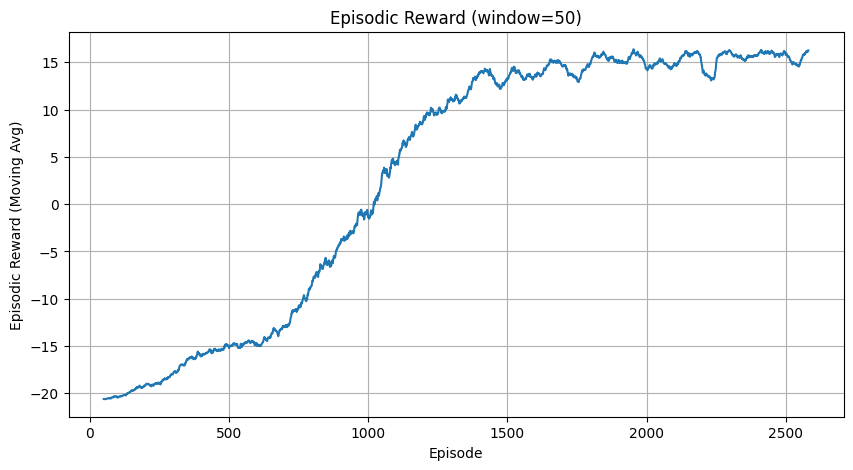

 99%|█████████▊| 14799/15000 [6:39:44<04:02,  1.21s/it]

Episode 14800 | Avg Episodic Reward (last 200): 16.28
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -10.5809
Critic Loss: 0.0043


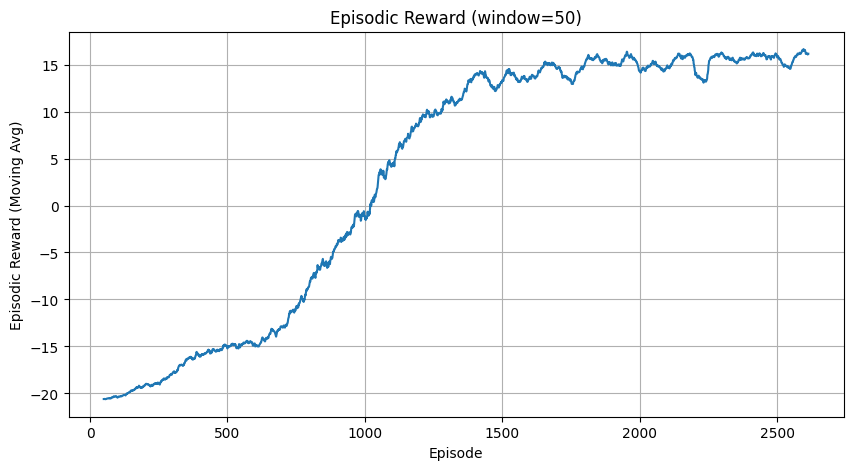

100%|█████████▉| 14999/15000 [6:43:52<00:01,  1.19s/it]

Episode 15000 | Avg Episodic Reward (last 200): 16.60
Actor LR: 0.0001
Critic LR: 1e-05
Actor Loss: -11.3352
Critic Loss: 0.0052


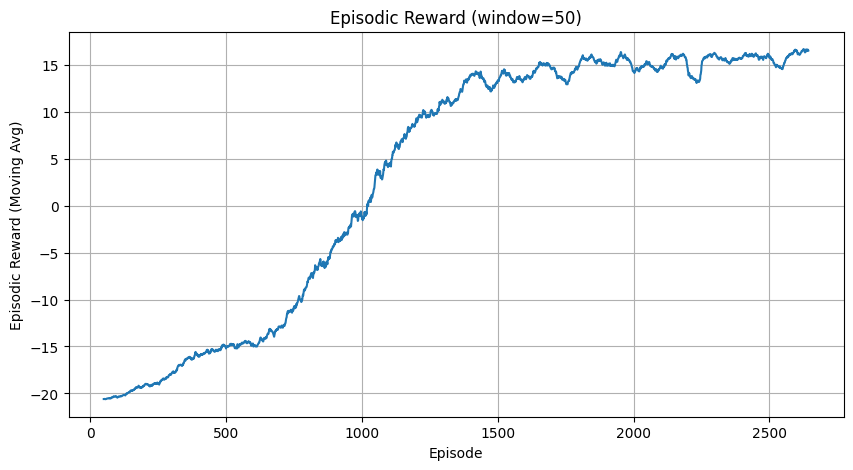

100%|██████████| 15000/15000 [6:43:53<00:00,  1.62s/it]


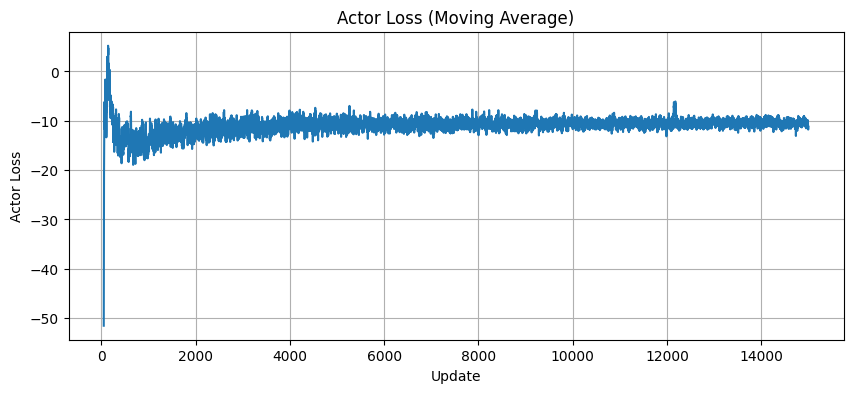

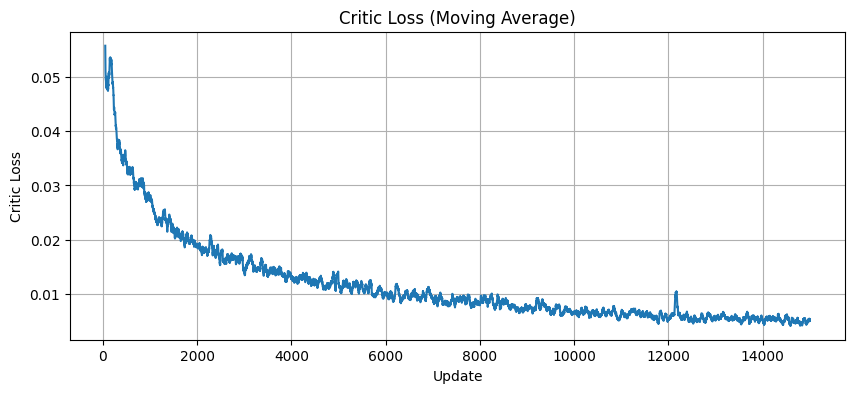

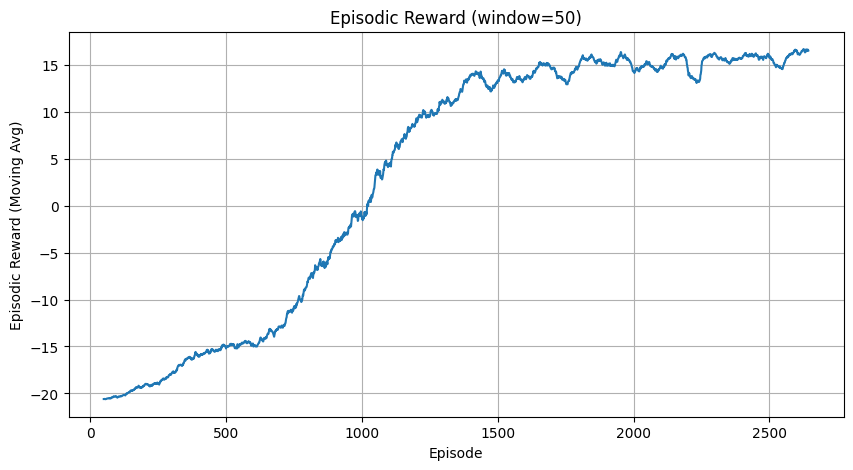

✅ Model saved


In [31]:


n_updates=15000
n_steps_per_update=128
gamma=0.95
Landa=0.95
states = envs.reset()   # reset ONCE
states = crop_states(states, threshold=128)


actor_loss_log = []
critic_loss_log = []
reward_log = []
episode_returns = np.zeros(n_envs)
episode_lengths = np.zeros(n_envs)
episodic_reward_log = []
episodic_rewards_all =[]

for ep in tqdm(range(n_updates)):

    logs_episode=torch.zeros(n_steps_per_update, n_envs, device=device)
    entropies_episode=torch.zeros(n_steps_per_update, n_envs, device=device)
    values_episode=torch.zeros(n_steps_per_update+1, n_envs, device=device)
    rewards_episode=torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)


    for step in range(n_steps_per_update):  

        actions, log_probs, values, entropies =agent.select_action(states)
       
       

        if ep == 100 and step==10 :
            state_env0 = states[2]     
            plot_state(state_env0, title="Training state (env 0)")
          

        states, rewards,dones, info=envs.step(actions.cpu().numpy())
      

        episode_returns += rewards
        episode_lengths += 1

 

        logs_episode[step] = log_probs
        entropies_episode[step] = entropies
        values_episode[step] = values.squeeze(-1)
        rewards_episode[step] = torch.tensor(rewards, device=device)
        masks[step] = torch.tensor(1.0 - dones, device=device)

        states = crop_states(states, threshold=128)


        for i in range(n_envs):
            if dones[i]:
                      
                 episodic_reward_log.append(episode_returns[i])
                 episodic_rewards_all.append(episode_returns[i]) 
                 episode_returns[i] = 0.0
                 episode_lengths[i] = 0


    if (ep + 1) % 200 == 0 and len(episodic_rewards_all) > 50:

       avg_ep_reward = np.mean(episodic_reward_log)
       episodic_reward_log=[]
       print(f"Episode {ep+1} | Avg Episodic Reward (last 200): {avg_ep_reward:.2f}")


       print("Actor LR:", agent.actor_optim.param_groups[0]["lr"])
       print("Critic LR:", agent.critic_optim.param_groups[0]["lr"])

       print(f"Actor Loss: {np.mean(actor_loss_log[-50:]):.4f}")
       print(f"Critic Loss: {np.mean(critic_loss_log[-50:]):.4f}")

       episodic_rewards = np.array(episodic_rewards_all)

       window = 50 
       ma_ep_rewards = np.convolve(
       episodic_rewards,
       np.ones(window) / window,
       mode="valid"
       )

       episodes = np.arange(window, len(episodic_rewards) + 1)

       plt.figure(figsize=(10, 5))
       plt.plot(episodes, ma_ep_rewards)
       plt.xlabel("Episode")
       plt.ylabel("Episodic Reward (Moving Avg)")
       plt.title(f"Episodic Reward (window={window})")
       plt.grid(True)
       plt.show()



    # IMPORTANT: bootstrap value
    with torch.no_grad():

        _, next_value = agent.forward(states)
        values_episode[-1] = next_value.squeeze(-1)

    # optimize
    actor_loss, critic_loss =agent.optimization(
        values=values_episode,
        logs=logs_episode,
        entropies=entropies_episode,
        rewards=rewards_episode,
        mask=masks,
        gamma=gamma,
        Landa=Landa,
        device=device
    )   
     
    actor_loss_log.append(actor_loss)
    critic_loss_log.append(critic_loss)  

envs.close()




# plot Actor Loss

window = 50

actor_ma = np.convolve(
    np.array(actor_loss_log),
    np.ones(window) / window,
    mode="valid"
)

episodes = np.arange(window, len(actor_loss_log) + 1)

plt.figure(figsize=(10, 4))
plt.plot(episodes, actor_ma)
plt.xlabel("Update")
plt.ylabel("Actor Loss")
plt.title("Actor Loss (Moving Average)")
plt.grid(True)
plt.show()


# plot Critic Loss


critic_ma = np.convolve(
    np.array(critic_loss_log),
    np.ones(window) / window,
    mode="valid"
)

episodes = np.arange(window, len(critic_loss_log) + 1)

plt.figure(figsize=(10, 4))
plt.plot(episodes, critic_ma)
plt.xlabel("Update")
plt.ylabel("Critic Loss")
plt.title("Critic Loss (Moving Average)")
plt.grid(True)
plt.show()

# plot Episodic Reward

episodic_rewards = np.array(episodic_rewards_all)

window = 50  

ma_ep_rewards = np.convolve(
    episodic_rewards,
    np.ones(window) / window,
    mode="valid"
)

episodes = np.arange(window, len(episodic_rewards) + 1)

plt.figure(figsize=(10, 5))
plt.plot(episodes, ma_ep_rewards)
plt.xlabel("Episode")
plt.ylabel("Episodic Reward (Moving Avg)")
plt.title(f"Episodic Reward (window={window})")
plt.grid(True)
plt.show()


#saving model

os.makedirs("checkpoints", exist_ok=True)
agent.save("checkpoints/a2c_pong.pth")
print("✅ Model saved")

        


In [35]:
device

device(type='cuda')

In [5]:
state_shape=(65,84,4)
use_cuda = True

if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
n_action=3
agent = ConvActorCritic(
    state_shape=state_shape,
    n_action=n_action,
    kernel_size=8,
    stride=1,
    padding=1,
    device=device,
    actor_lr=1e-4,
    critic_lr=1e-5
)

agent.load("checkpoints/a2c_pong.pth", device)
agent.eval()  # IMPORTANT



C:\Users\ASUS\AppData\Local\Temp\ipykernel_10036\320767113.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


ConvActorCritic(
  (actor_conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (actor_fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
  (critic_conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (critic_fc): Sequentia

In [7]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo, FrameStackObservation
from stable_baselines3.common.atari_wrappers import AtariWrapper
import torch
import numpy as np
import os

# ----------------------------
# Make test environment
# ----------------------------
def make_test_env(video_folder="videos"):
    env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
    env = AtariWrapper(env,
    frame_skip=1, 
    terminal_on_life_loss=False)
    env = PongMinimalActionWrapper(env)
   
    # ✅ Gymnasium-native frame stack
    env = FrameStackObservation(env, stack_size=4)

    
    # ✅ Video recording
    env = RecordVideo(env, video_folder=video_folder,
                      episode_trigger=lambda e: True,
                      name_prefix="a2c_pong_test")
    return env

# ----------------------------
# Initialize environment
# ----------------------------
os.makedirs("videos", exist_ok=True)
test_env = make_test_env("videos")

print("Action space:", test_env.action_space)


# ----------------------------
# Run 6 test episodes
# ----------------------------
n_episodes = 6
episode_rewards = []

for ep in range(n_episodes):
    state, _ = test_env.reset()

    done = False
    ep_reward = 0
    step=0
    while not done:
         # state shape: (stack, H, W, C) = (4, 84, 84, 1)
        state = np.squeeze(state, axis=3)         # -> (stack, H, W) = (4, 84, 84)
        state = state[:, 13:78, :]    
        state=(state >= 128).astype(np.uint8) * 255
              # -> (4, 65, 84)

        state = np.transpose(state, (1, 2, 0))   # -> (H, W, C) = (84, 84, 4)
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # -> (1, H, W, C)

     
        with torch.no_grad():
            logits, _ = agent.forward(state_tensor)
            # Sample action from policy
            #dist = torch.distributions.Categorical(logits=logits)
            #action = dist.sample().item()
            action = torch.argmax(logits, dim=1).item()

        
        # Step environment
        state, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        ep_reward += reward
        step+=1



    print(f"Episode {ep+1}: Reward = {ep_reward}")
    episode_rewards.append(ep_reward)

test_env.close()
print("✅ Test completed. Videos saved to 'videos/'")


Action space: Discrete(3)
Episode 1: Reward = 21.0
Episode 2: Reward = 19.0
Episode 3: Reward = 21.0
Episode 4: Reward = 21.0
Episode 5: Reward = 19.0
Episode 6: Reward = 20.0
✅ Test completed. Videos saved to 'videos/'


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(agent)
trainable_params = count_trainable_parameters(agent)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

def model_size_mb(model):
    size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    return size_bytes / (1024 ** 2)

print(f"Model size: {model_size_mb(agent):.2f} MB")



Total parameters: 411,460
Trainable parameters: 411,460
Model size: 1.57 MB
